In [31]:
!pip install rdkit

In [32]:
# %% Cell 1: Imports and Setup
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, Lipinski, rdMolDescriptors, MACCSkeys, rdDepictor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
try:
    import plotly.express as px
    has_plotly = True
except ImportError:
    has_plotly = False

sns.set(style="whitegrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 6)

In [33]:
# %% Cell 2: Define Molecules and Compute 2D Coordinates
smiles_dict = {
    "Benzene": "c1ccccc1",
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O",
    "Ethanol": "CCO",
    "Triethylamine": "CCN(CC)CC",
    "Pyridine": "c1ccncc1"
}
mols = {}
for name, smi in smiles_dict.items():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    rdDepictor.Compute2DCoords(mol)
    mols[name] = mol

In [34]:
# %% Cell 2: Define Molecules and Compute 2D Coordinates
smiles_dict = {
    "Benzene": "c1ccccc1",
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O",
    "Ethanol": "CCO",
    "Triethylamine": "CCN(CC)CC",
    "Pyridine": "c1ccncc1"
}
mols = {}
for name, smi in smiles_dict.items():
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    rdDepictor.Compute2DCoords(mol)
    mols[name] = mol

In [35]:
# %% Cell 3: Compute Primary Descriptors Function
def compute_primary_descriptors(mol):
    d = {}
    d["MolWt"] = Descriptors.MolWt(mol)
    d["LogP"] = Descriptors.MolLogP(mol)
    d["HBD"] = Lipinski.NumHDonors(mol)
    d["HBA"] = Lipinski.NumHAcceptors(mol)
    d["TPSA"] = rdMolDescriptors.CalcTPSA(mol)
    d["RotBonds"] = Lipinski.NumRotatableBonds(mol)
    return d

In [36]:
# %% Cell 4: Build Descriptor DataFrame
desc_list = []
for name, mol in mols.items():
    d = compute_primary_descriptors(mol)
    d["Name"] = name
    desc_list.append(d)
desc_df = pd.DataFrame(desc_list)
print(desc_df)

     MolWt    LogP  HBD  HBA   TPSA  RotBonds           Name
0   78.114  1.6866    0    0   0.00         0        Benzene
1  180.159  1.3101    1    3  63.60         2        Aspirin
2   46.069 -0.0014    1    1  20.23         0        Ethanol
3  101.193  1.3481    0    1   3.24         3  Triethylamine
4   79.102  1.0816    0    1  12.89         0       Pyridine


In [37]:
# %% Cell 5: Compute Extended Descriptors (Minimal)
def compute_extended_descriptors(mol):
    ext_desc = {}
    for desc_name, func in Descriptors._descList:
        try:
            ext_desc[desc_name] = func(mol)
        except Exception:
            ext_desc[desc_name] = np.nan
    return ext_desc

extended_desc_dict = {}
for name, mol in mols.items():
    extended_desc_dict[name] = compute_extended_descriptors(mol)
extended_desc_df = pd.DataFrame(extended_desc_dict).T
extended_desc_df.reset_index(inplace=True)
extended_desc_df.rename(columns={'index':'Name'}, inplace=True)
print(extended_desc_df.head(10))

            Name  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0        Benzene           2.000000        2.000000           2.000000   
1        Aspirin          10.611948       10.611948           0.016019   
2        Ethanol           7.569444        7.569444           0.250000   
3  Triethylamine           2.375000        2.375000           1.187500   
4       Pyridine           3.784722        3.784722           1.750000   

   MinEStateIndex       qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0        2.000000  0.442628   8.000000   78.114          72.066   78.046950   
1       -1.114028  0.550122   9.307692  180.159         172.095  180.042259   
2        0.250000  0.406808   6.000000   46.069          40.021   46.041865   
3        1.187500  0.518375  10.285714  101.193          86.073  101.120449   
4        1.750000  0.453148   8.000000   79.102          74.062   79.042199   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \

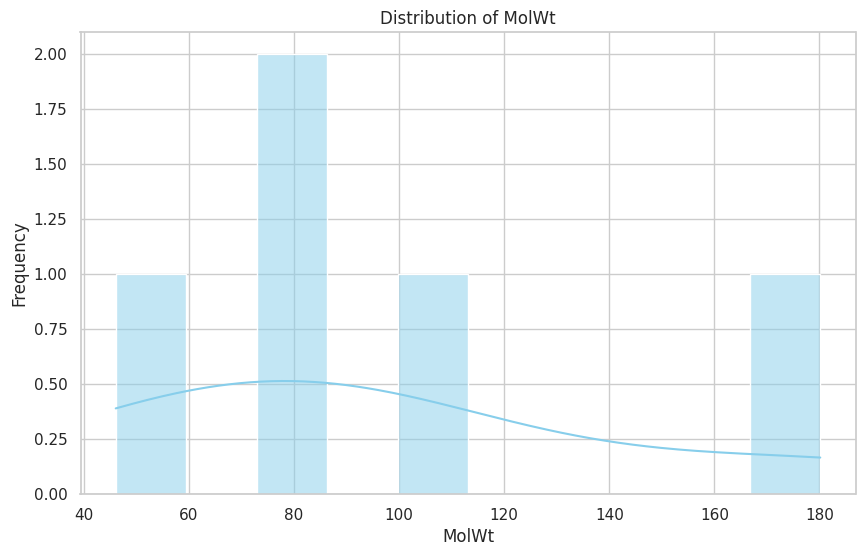

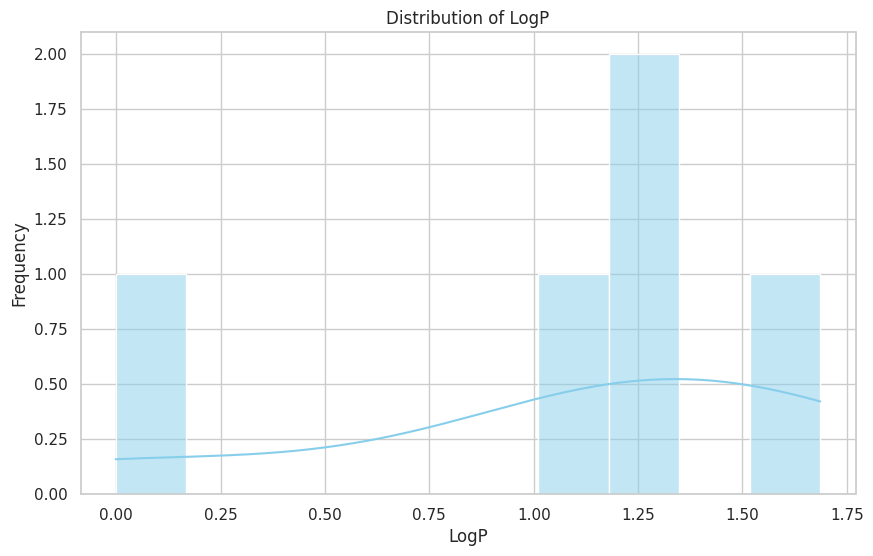

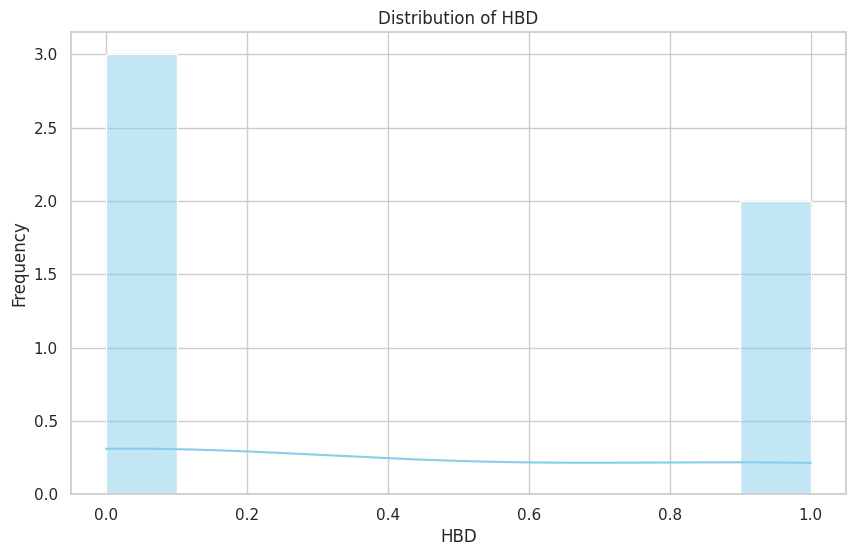

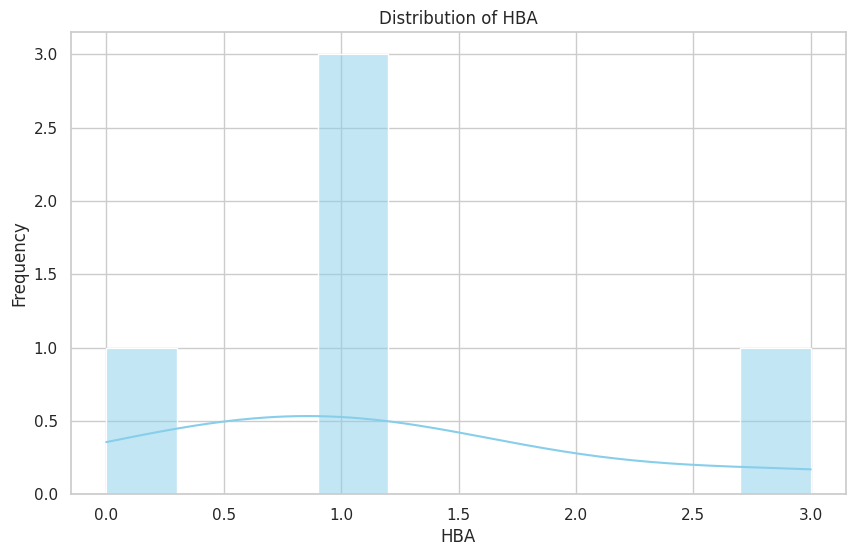

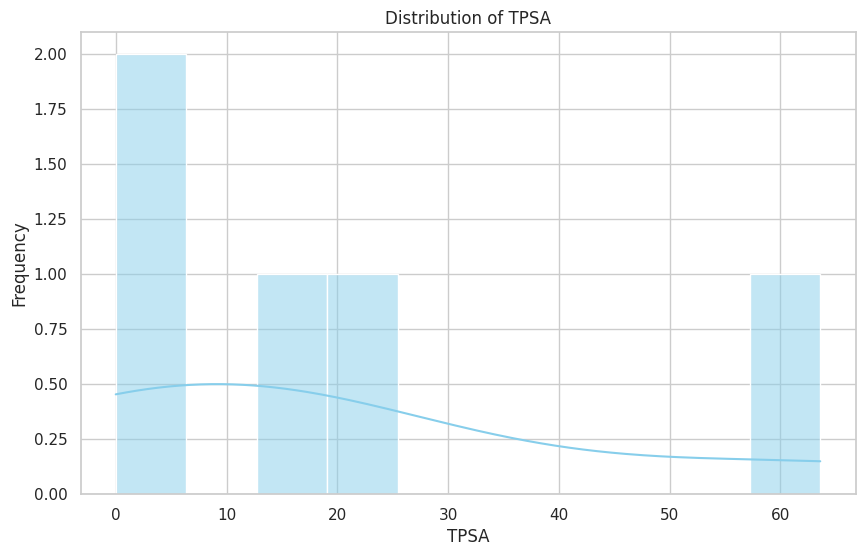

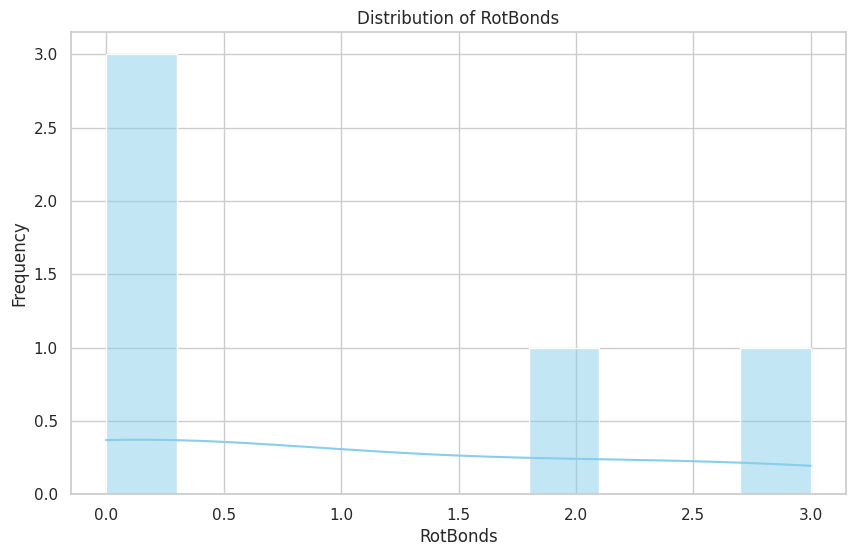

In [38]:
# %% Cell 6: Visualize Descriptor Distributions
features = ["MolWt", "LogP", "HBD", "HBA", "TPSA", "RotBonds"]
for feature in features:
    plt.figure()
    sns.histplot(desc_df[feature], bins=10, kde=True, color="skyblue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

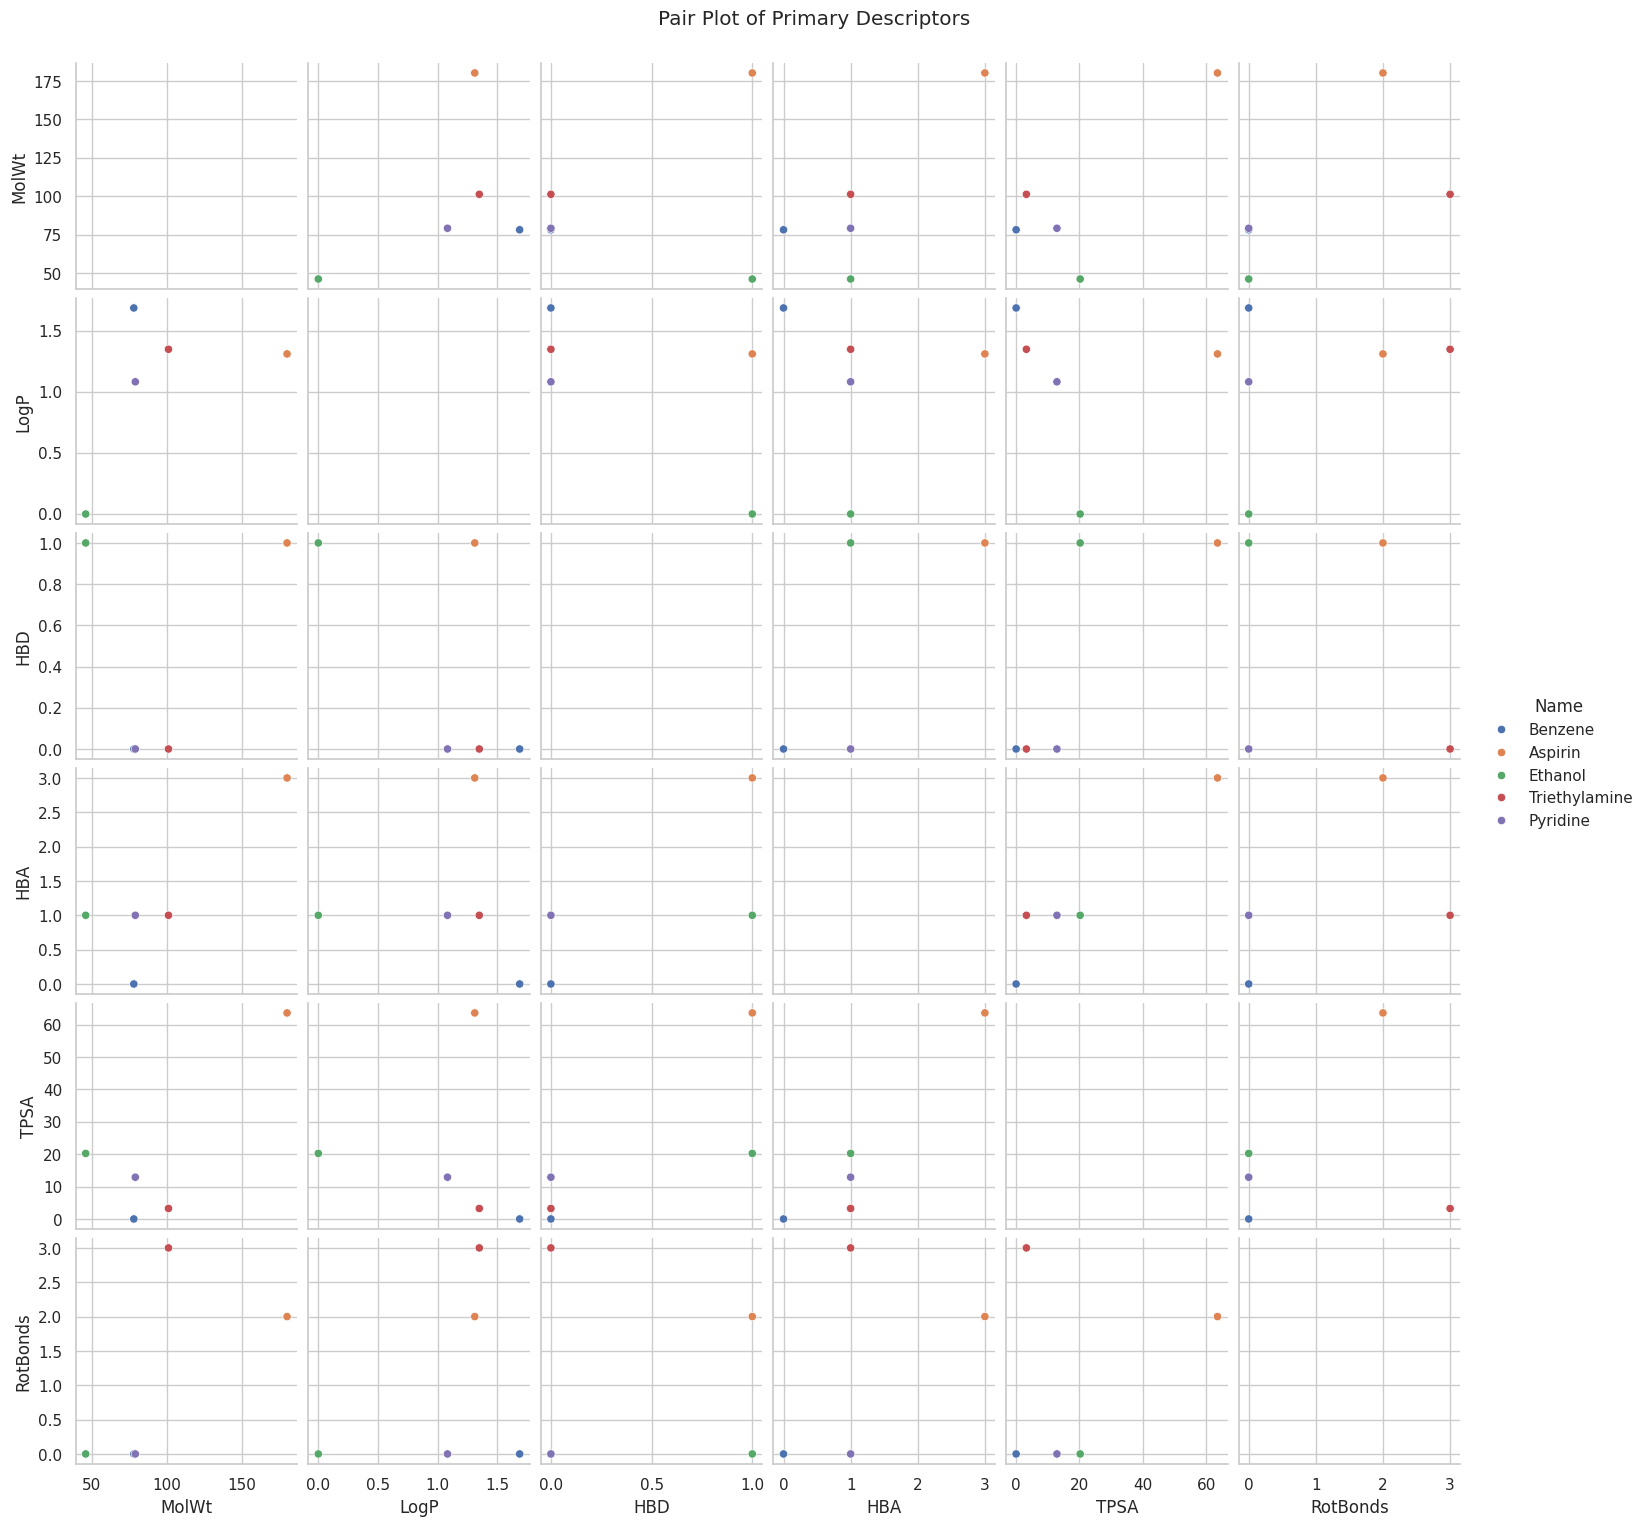

In [39]:
# %% Cell 7: Pair Plot of Primary Descriptors
sns.pairplot(desc_df[features + ["Name"]], hue="Name", diag_kind="kde")
plt.suptitle("Pair Plot of Primary Descriptors", y=1.02)
plt.show()

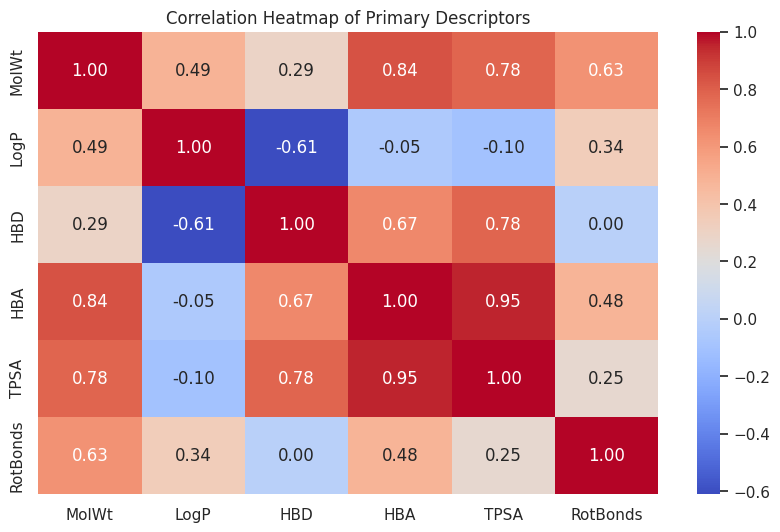

In [40]:
# %% Cell 8: Correlation Matrix Heatmap
corr_matrix = desc_df[features].corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Primary Descriptors")
plt.show()

In [41]:
# %% Cell 9: Standardize Descriptor Data
X = desc_df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Standardized Data:\n", X_scaled)

Standardized Data:
 [[-0.41645484  1.04343517 -0.81649658 -1.22474487 -0.87128486 -0.79056942]
 [ 1.84242096  0.39042097  1.22474487  1.83711731  1.90050971  0.79056942]
 [-1.12580537 -1.88428851  1.22474487 -0.20412415  0.01037244 -0.79056942]
 [ 0.09442364  0.45632944 -0.81649658 -0.20412415 -0.73008023  1.58113883]
 [-0.39458439 -0.00589707 -0.81649658 -0.20412415 -0.30951706 -0.79056942]]


In [42]:
# %% Cell 10: Perform PCA on Standardized Data
# Change n_components to be less than or equal to the minimum of n_samples and n_features (5 in this case)
pca_full = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]))  # Use min(n_samples, n_features)
X_pca_full = pca_full.fit_transform(X_scaled)
print("Explained Variance Ratio:", pca_full.explained_variance_ratio_)
print("PCA Components:\n", pca_full.components_)

Explained Variance Ratio: [5.66895753e-01 3.19620431e-01 9.55740324e-02 1.79097834e-02
 5.12532472e-33]
PCA Components:
 [[ 0.47657341  0.00948382  0.371668    0.53273833  0.51750634  0.28814544]
 [ 0.32527449  0.67486435 -0.49630422 -0.03768802 -0.14603865  0.41193333]
 [-0.20597176 -0.44079463  0.03430635  0.00089345 -0.28687797  0.82449926]
 [ 0.04750698  0.37190191  0.72894741 -0.54511259 -0.09523524  0.14781829]
 [ 0.78890607 -0.42039518 -0.05321636 -0.26987863 -0.32565808 -0.13847547]]


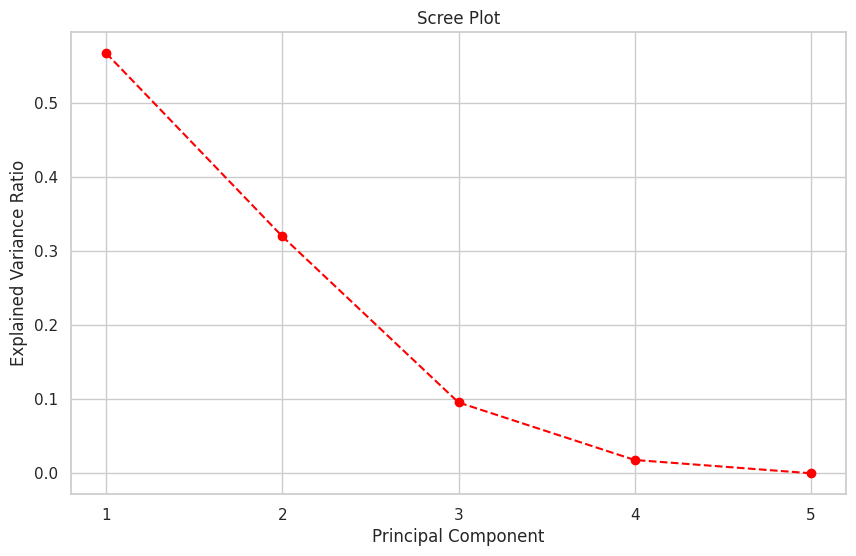

In [43]:
# %% Cell 11: Plot Scree Plot (Explained Variance)
evr = pca_full.explained_variance_ratio_
plt.figure()
plt.plot(range(1, len(evr)+1), evr, marker='o', linestyle='--', color='red')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.xticks(range(1, len(evr)+1))
plt.show()

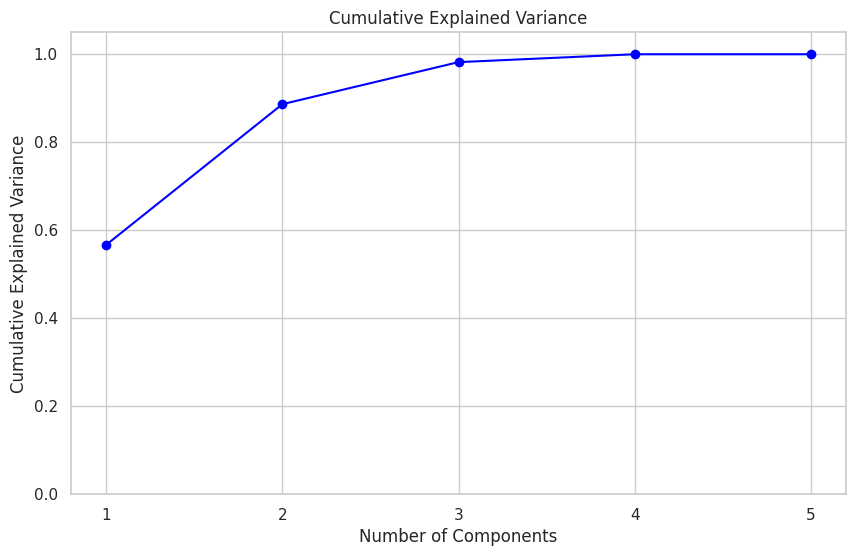

In [44]:
# %% Cell 12: Plot Cumulative Explained Variance
cum_evr = np.cumsum(evr)
plt.figure()
plt.plot(range(1, len(cum_evr)+1), cum_evr, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance")
plt.xticks(range(1, len(cum_evr)+1))
plt.ylim(0, 1.05)
plt.show()

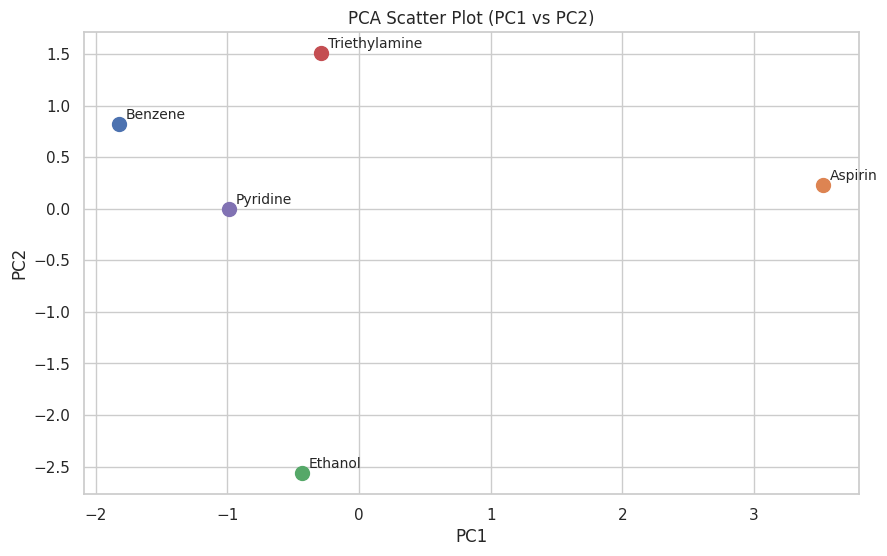

In [45]:
# %% Cell 13: PCA Scatter Plot (PC1 vs PC2)
names = desc_df["Name"].tolist()
plt.figure()
for i, name in enumerate(names):
    plt.scatter(X_pca_full[i, 0], X_pca_full[i, 1], s=100)
    plt.text(X_pca_full[i, 0]+0.05, X_pca_full[i, 1]+0.05, name, fontsize=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot (PC1 vs PC2)")
plt.grid(True)
plt.show()

In [47]:
# %% Cell 14: Function for PCA Analysis
def run_pca_analysis(data, feature_cols):
    X = data[feature_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Change n_components to be the minimum of n_samples and n_features
    pca_model = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]))
    X_pca = pca_model.fit_transform(X_scaled)
    return X_scaled, pca_model, X_pca, scaler

X_scaled, pca_model, X_pca, scaler = run_pca_analysis(desc_df, features)

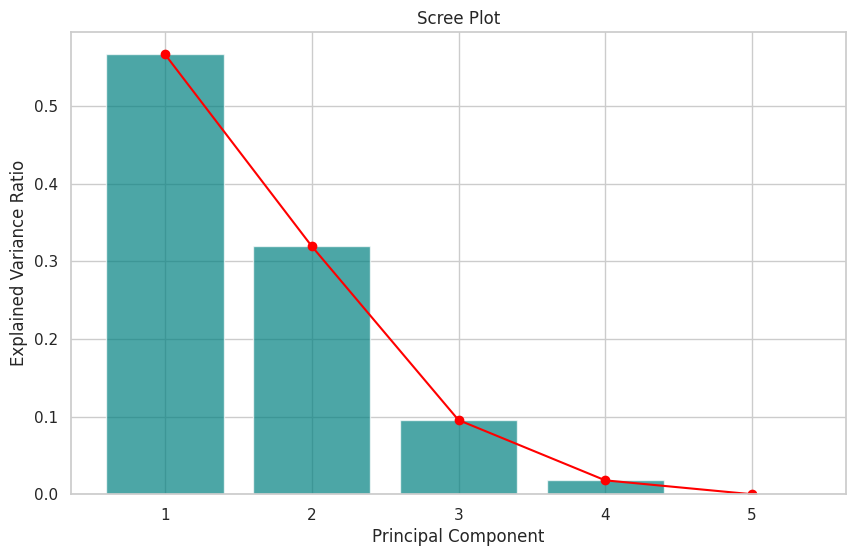

In [48]:
# %% Cell 15: Function to Plot Scree Plot
def plot_scree(pca_model):
    evr = pca_model.explained_variance_ratio_
    plt.figure()
    plt.bar(range(1, len(evr)+1), evr, alpha=0.7, color='teal')
    plt.plot(range(1, len(evr)+1), evr, marker='o', color='red')
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Scree Plot")
    plt.xticks(range(1, len(evr)+1))
    plt.show()

plot_scree(pca_model)

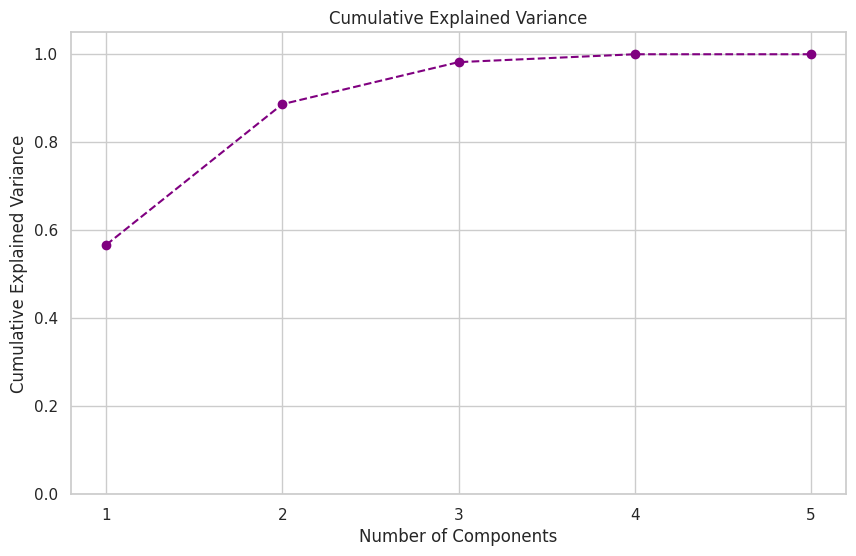

In [49]:
# %% Cell 16: Function to Plot Cumulative Variance
def plot_cumulative_variance(pca_model):
    cum_var = np.cumsum(pca_model.explained_variance_ratio_)
    plt.figure()
    plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', linestyle='--', color='purple')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.xticks(range(1, len(cum_var)+1))
    plt.ylim(0, 1.05)
    plt.show()

plot_cumulative_variance(pca_model)

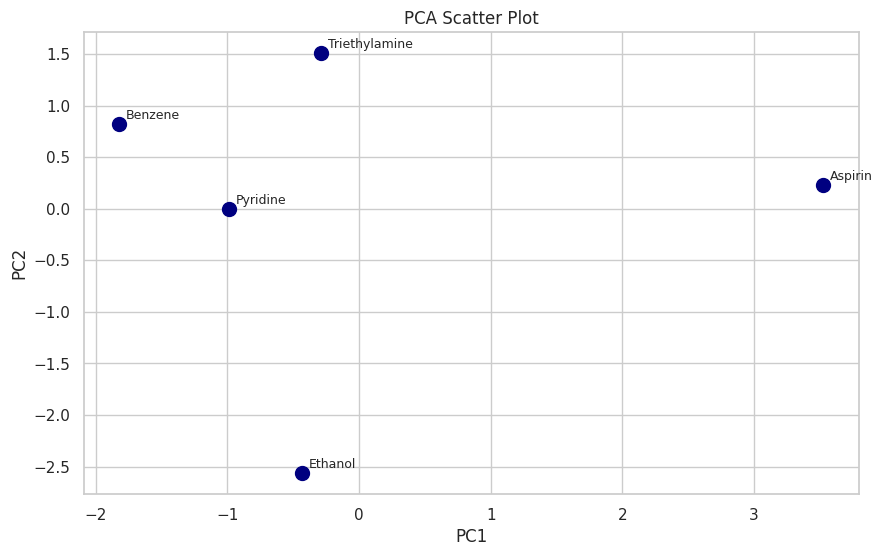

In [50]:
# %% Cell 17: Function to Plot PCA Scatter Plot
def plot_pca_scatter(scores, names):
    plt.figure()
    for i, name in enumerate(names):
        plt.scatter(scores[i, 0], scores[i, 1], s=100, color='navy')
        plt.text(scores[i, 0]+0.05, scores[i, 1]+0.05, name, fontsize=9)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Scatter Plot")
    plt.grid(True)
    plt.show()

plot_pca_scatter(X_pca, names)

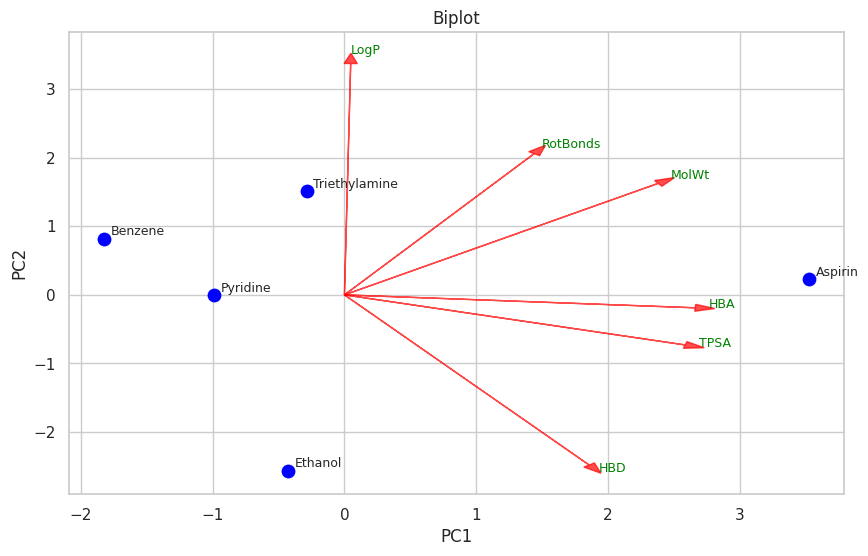

In [51]:
# %% Cell 18: Function to Plot Biplot
def plot_biplot(scores, loadings, names, feature_names):
    xs = scores[:, 0]
    ys = scores[:, 1]
    plt.figure()
    plt.scatter(xs, ys, s=80, color='blue')
    for i, name in enumerate(names):
        plt.text(xs[i]+0.05, ys[i]+0.05, name, fontsize=9)
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[0, i]*5, loadings[1, i]*5, color='red', alpha=0.7, head_width=0.1)
        plt.text(loadings[0, i]*5.2, loadings[1, i]*5.2, feature, color='green', fontsize=9)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.show()

plot_biplot(X_pca, pca_model.components_, names, features)

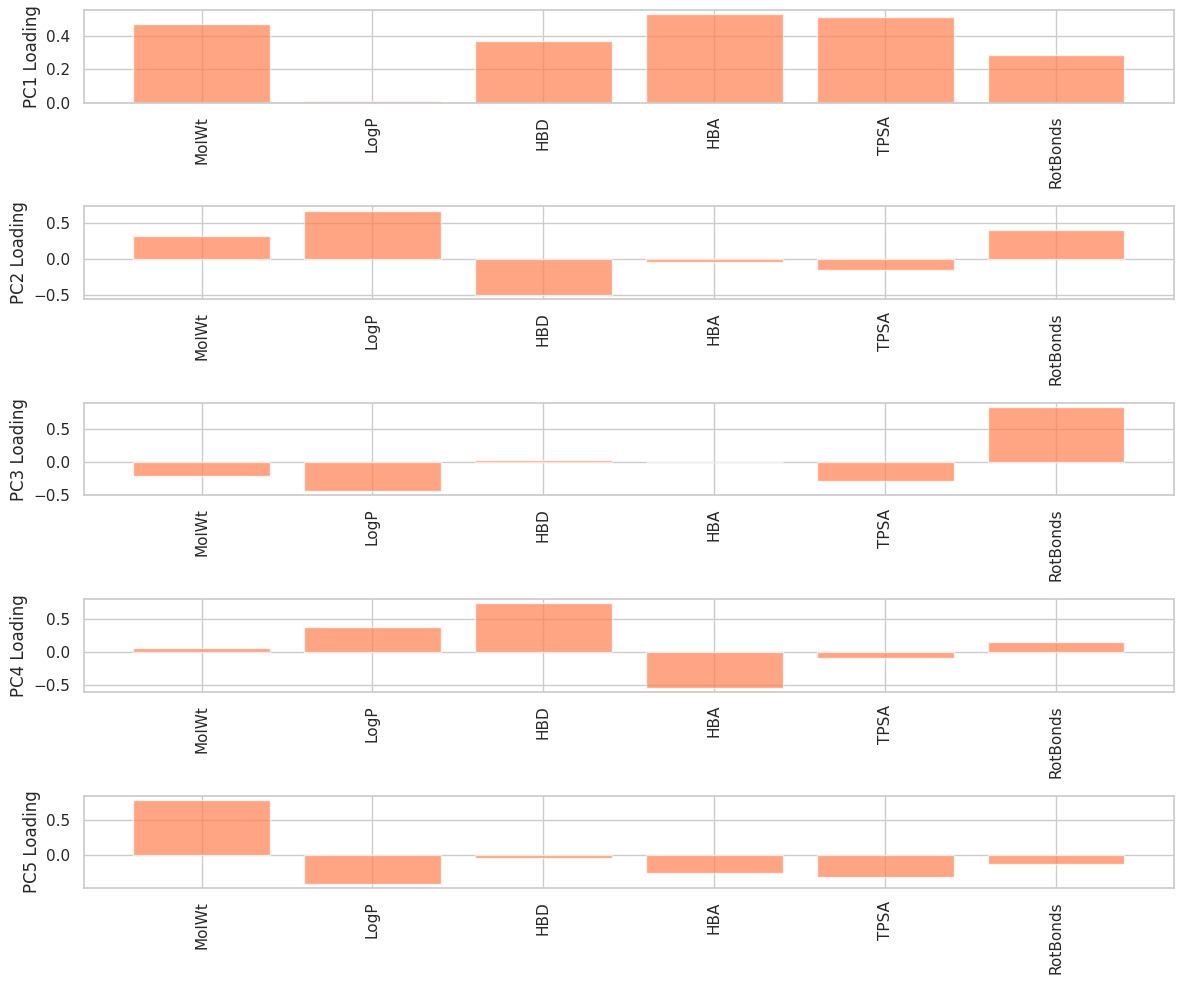

In [52]:
# %% Cell 19: Function to Plot Loadings for Each Component
def plot_loadings(pca_model, feature_names):
    num_components = pca_model.components_.shape[0]
    plt.figure(figsize=(12, num_components * 2))
    for i in range(num_components):
        plt.subplot(num_components, 1, i+1)
        plt.bar(range(len(feature_names)), pca_model.components_[i], alpha=0.7, color='coral')
        plt.xticks(range(len(feature_names)), feature_names, rotation=90)
        plt.ylabel(f"PC{i+1} Loading")
    plt.tight_layout()
    plt.show()

plot_loadings(pca_model, features)

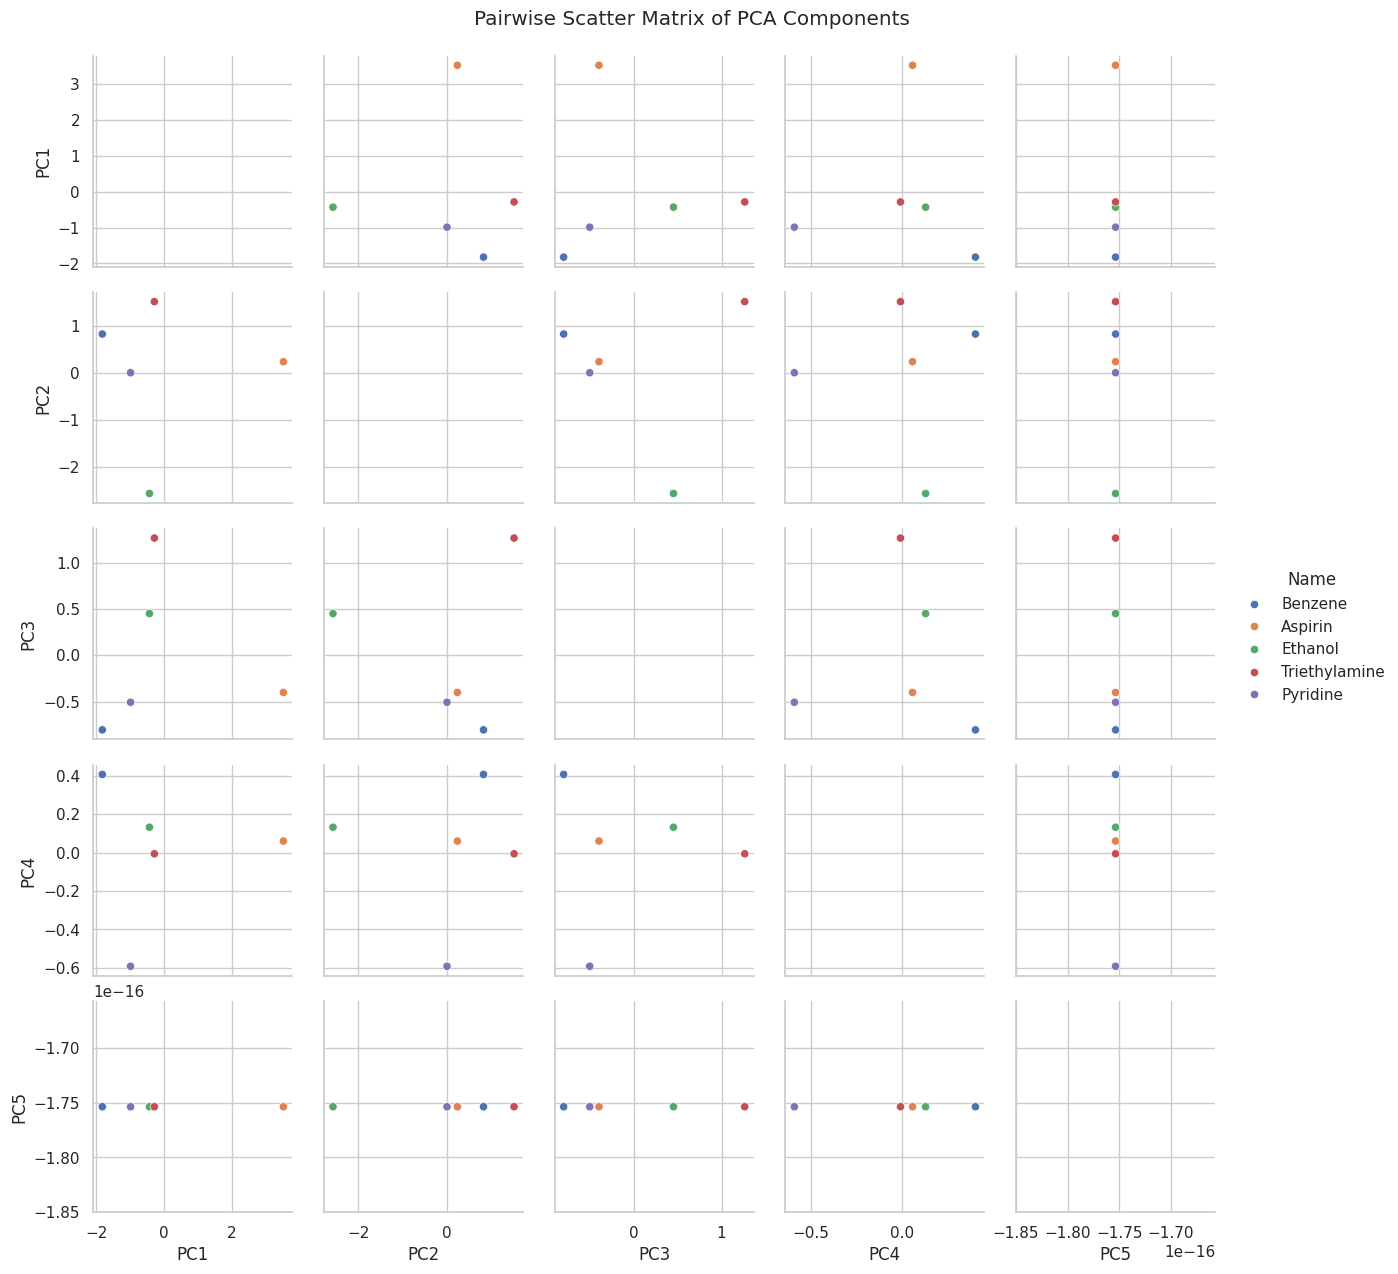

In [53]:
# %% Cell 20: Pairwise Scatter Matrix of PCA Components
pca_columns = [f"PC{i+1}" for i in range(X_pca.shape[1])]
pca_df = pd.DataFrame(X_pca, columns=pca_columns)
pca_df["Name"] = names
sns.pairplot(pca_df, hue="Name", diag_kind="kde")
plt.suptitle("Pairwise Scatter Matrix of PCA Components", y=1.02)
plt.show()

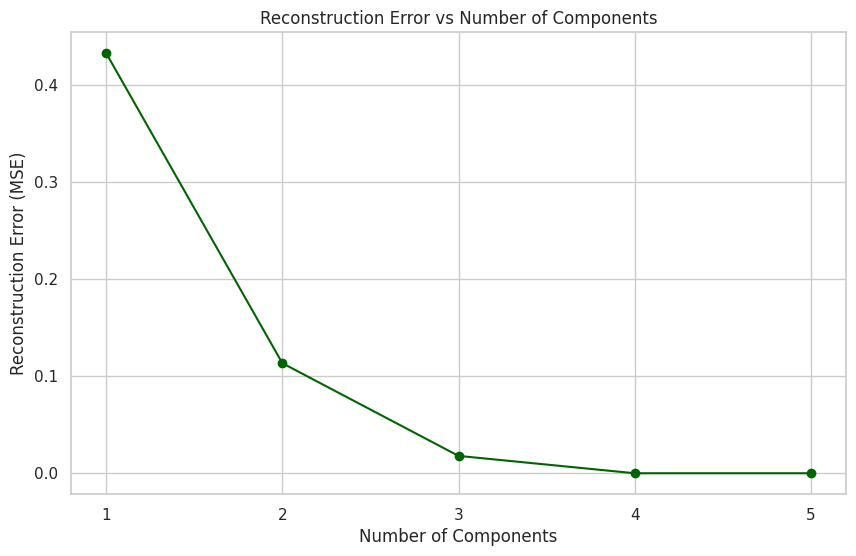

In [56]:
# %% Cell 21: Reconstruction Error Analysis for PCA
reconstruction_errors = []
components_range = list(range(1, len(features)+1))  # Original line
# Change the range to be from 1 to min(number of samples, number of features)
components_range = list(range(1, min(X_scaled.shape[0], X_scaled.shape[1]) + 1))
for n in components_range:
    pca_n = PCA(n_components=n)
    X_pca_n = pca_n.fit_transform(X_scaled)
    X_reconstructed = pca_n.inverse_transform(X_pca_n)
    mse = np.mean((X_scaled - X_reconstructed)**2)
    reconstruction_errors.append(mse)
plt.figure()
plt.plot(components_range, reconstruction_errors, marker='o', linestyle='-', color='darkgreen')
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Reconstruction Error vs Number of Components")
plt.xticks(components_range)
plt.show()

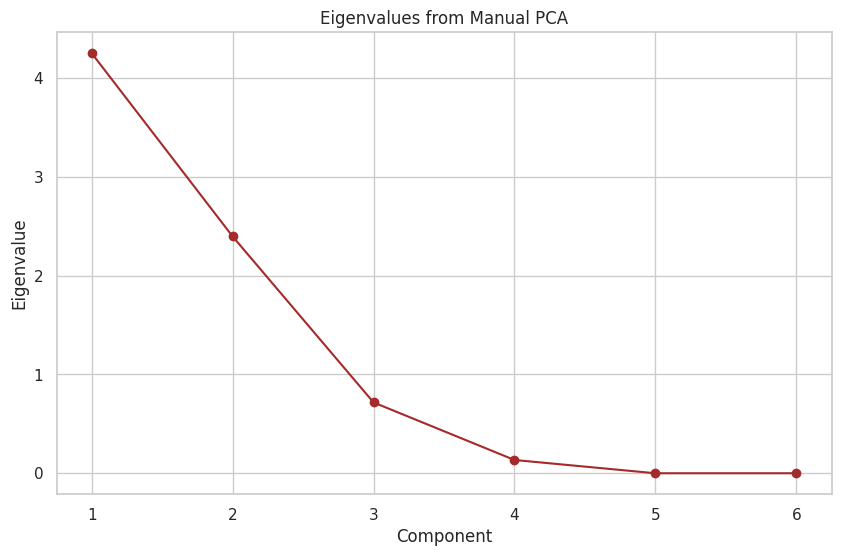

In [57]:
# %% Cell 22: PCA Step-by-Step (Manual Calculation)
def pca_manual(X):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_matrix)
    sorted_idx = np.argsort(eigen_vals)[::-1]
    eigen_vals_sorted = eigen_vals[sorted_idx]
    eigen_vecs_sorted = eigen_vecs[:, sorted_idx]
    X_reduced = np.dot(X_centered, eigen_vecs_sorted)
    return X_centered, cov_matrix, eigen_vals_sorted, eigen_vecs_sorted, X_reduced, X_mean

X_centered, cov_matrix, eigen_vals, eigen_vecs, X_reduced, X_mean = pca_manual(X_scaled)
plt.figure()
plt.plot(range(1, len(eigen_vals)+1), eigen_vals, marker='o', linestyle='-', color='brown')
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues from Manual PCA")
plt.xticks(range(1, len(eigen_vals)+1))
plt.show()

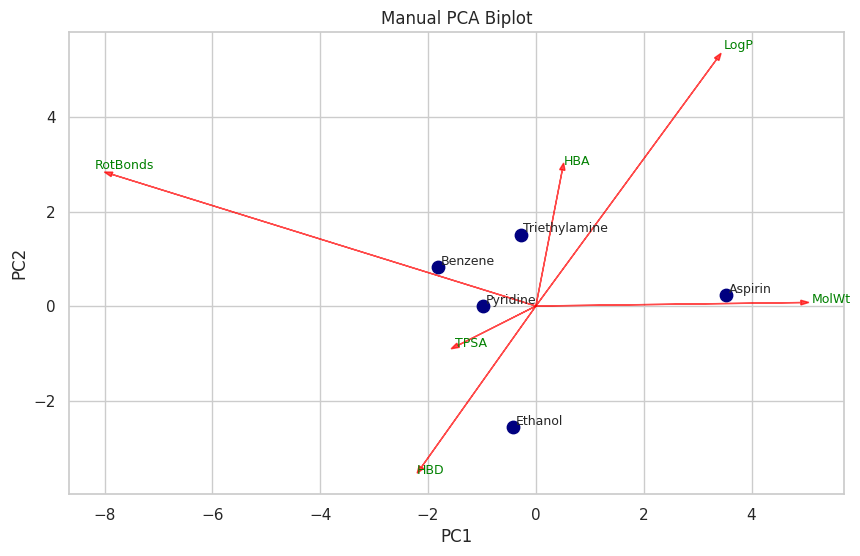

In [58]:
# %% Cell 23: Manual Biplot Using Eigenvectors and Eigenvalues
def manual_biplot(X_centered, eigen_vecs, eigen_vals, names, feature_names):
    scores = np.dot(X_centered, eigen_vecs)
    plt.figure()
    plt.scatter(scores[:, 0], scores[:, 1], s=80, color='navy')
    for i, name in enumerate(names):
        plt.text(scores[i, 0]+0.05, scores[i, 1]+0.05, name, fontsize=9)
    for i in range(len(feature_names)):
        plt.arrow(0, 0, eigen_vecs[0, i]*np.sqrt(eigen_vals[0])*5, eigen_vecs[1, i]*np.sqrt(eigen_vals[1])*5, color='red', alpha=0.7, head_width=0.1)
        plt.text(eigen_vecs[0, i]*np.sqrt(eigen_vals[0])*5.2, eigen_vecs[1, i]*np.sqrt(eigen_vals[1])*5.2, feature_names[i], color='green', fontsize=9)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Manual PCA Biplot")
    plt.grid(True)
    plt.show()

manual_biplot(X_centered, eigen_vecs, eigen_vals, names, features)

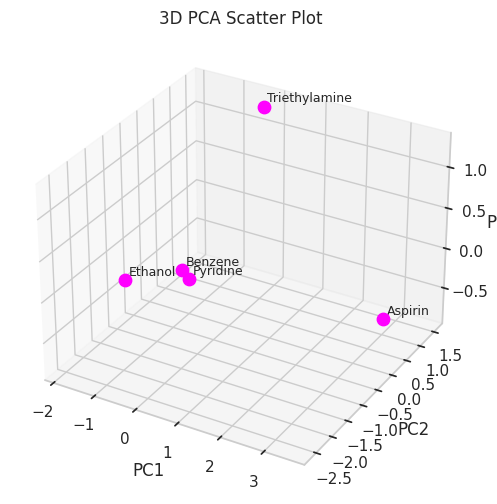

In [59]:
# %% Cell 24: 3D PCA Scatter Plot
pca_3 = PCA(n_components=3)
X_pca_3 = pca_3.fit_transform(X_scaled)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, name in enumerate(names):
    ax.scatter(X_pca_3[i, 0], X_pca_3[i, 1], X_pca_3[i, 2], s=80, color='magenta')
    ax.text(X_pca_3[i, 0]+0.05, X_pca_3[i, 1]+0.05, X_pca_3[i, 2]+0.05, name, fontsize=9)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Scatter Plot")
plt.show()

In [60]:
# %% Cell 25: Interactive 3D PCA Scatter Plot (Plotly)
if has_plotly:
    pca_3_df = pd.DataFrame(X_pca_3, columns=["PC1", "PC2", "PC3"])
    pca_3_df["Name"] = names
    fig = px.scatter_3d(pca_3_df, x='PC1', y='PC2', z='PC3', color='Name', text='Name', title="Interactive 3D PCA Scatter Plot")
    fig.show()
else:
    print("Plotly not installed. Skipping interactive 3D plot.")

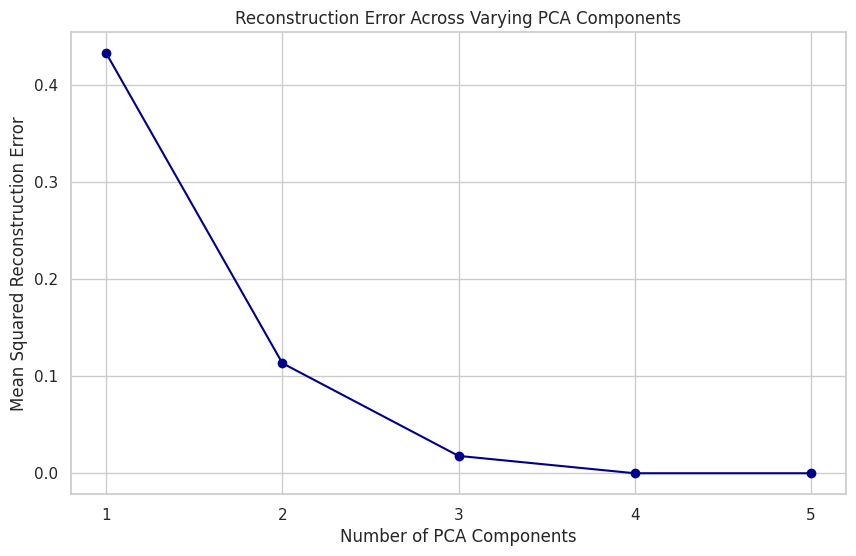

In [63]:
# %% Cell 26: Function to Reconstruct Data and Compute Error for Varying Components
def compute_reconstruction_errors(X_scaled, max_components):
    errors = []
    # Change the range to be from 1 to min(number of samples, number of features)
    for n in range(1, min(X_scaled.shape[0], X_scaled.shape[1]) + 1):
        pca_n = PCA(n_components=n)
        X_pca_n = pca_n.fit_transform(X_scaled)
        X_reconstructed = pca_n.inverse_transform(X_pca_n)
        mse = np.mean((X_scaled - X_reconstructed)**2)
        errors.append(mse)
    return errors

max_comps = len(features)
# Adjust max_comps to be the minimum of n_samples and n_features
max_comps = min(X_scaled.shape[0], X_scaled.shape[1])
reconstruction_errors = compute_reconstruction_errors(X_scaled, max_comps)
plt.figure()
plt.plot(range(1, max_comps+1), reconstruction_errors, marker='o', linestyle='-', color='darkblue')
plt.xlabel("Number of PCA Components")
plt.ylabel("Mean Squared Reconstruction Error")
plt.title("Reconstruction Error Across Varying PCA Components")
plt.xticks(range(1, max_comps+1))
plt.show()

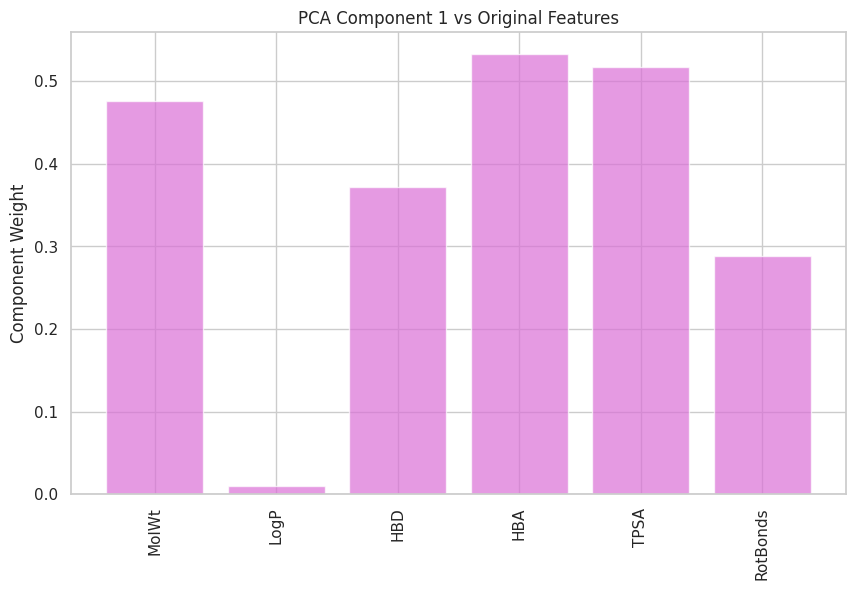

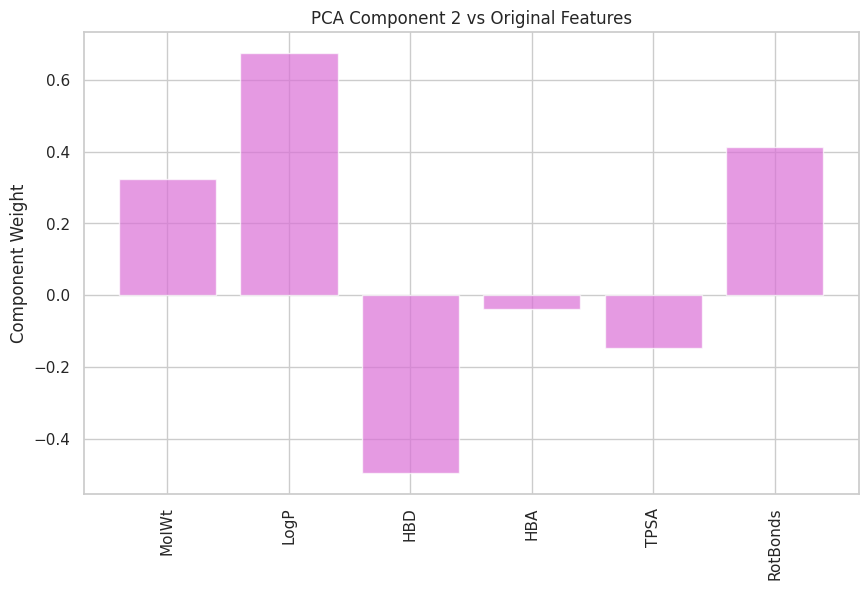

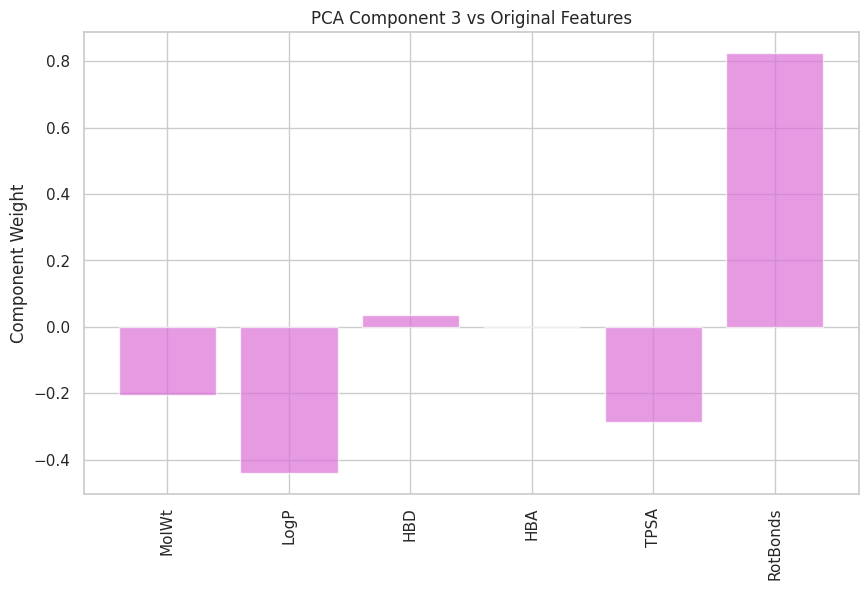

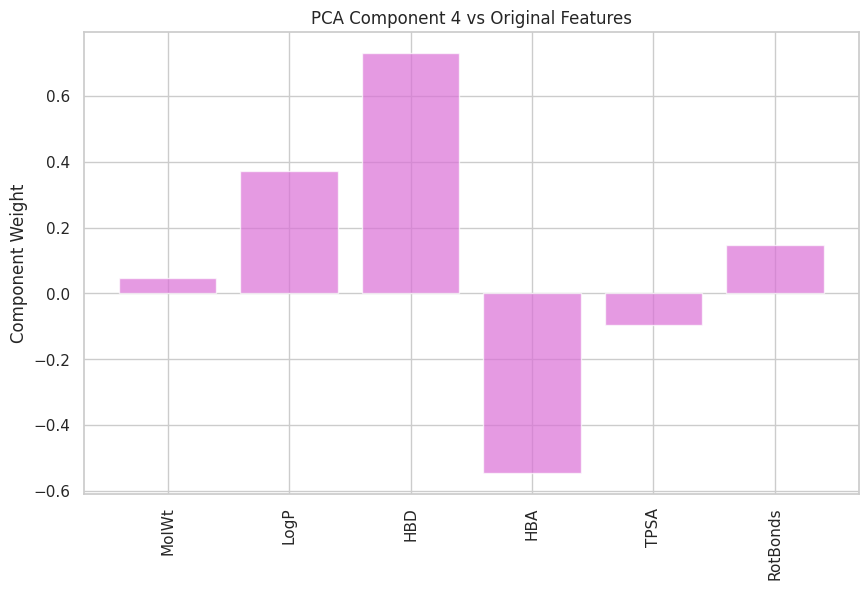

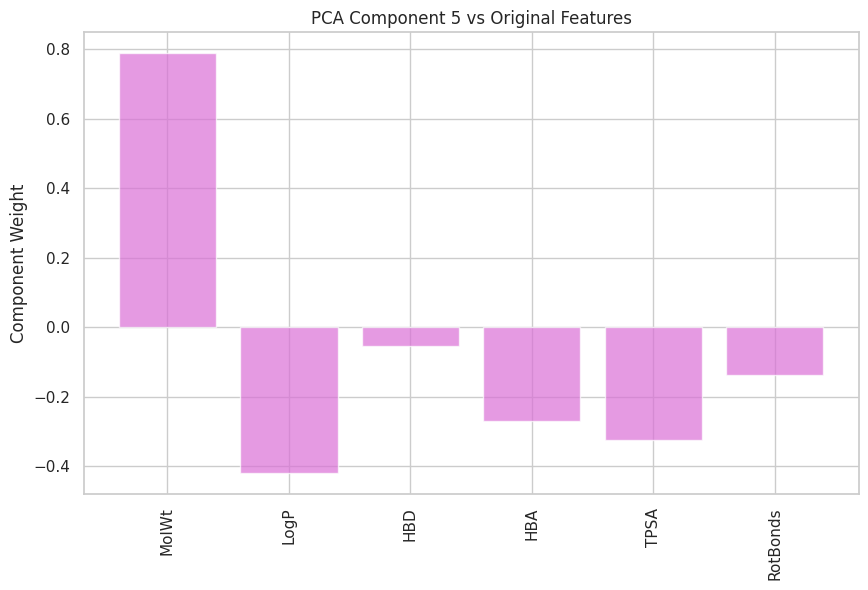

IndexError: index 5 is out of bounds for axis 0 with size 5

In [64]:

# %% Cell 27: Function to Visualize PCA Components vs Original Features
def plot_component_vs_feature(pca_model, scaler, feature_names, component_index=0):
    comp = pca_model.components_[component_index]
    plt.figure()
    plt.bar(range(len(feature_names)), comp, color='orchid', alpha=0.7)
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.ylabel("Component Weight")
    plt.title(f"PCA Component {component_index+1} vs Original Features")
    plt.show()

for i in range(len(features)):
    plot_component_vs_feature(pca_model, scaler, features, component_index=i)

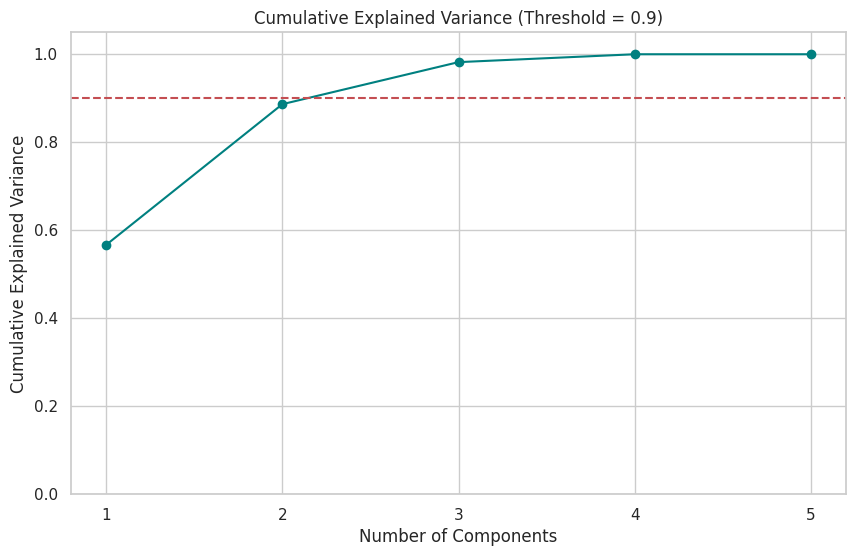

In [65]:
# %% Cell 28: Function to Plot Cumulative Explained Variance with Threshold Line
def plot_cumulative_variance_threshold(pca_model, threshold=0.9):
    cum_var = np.cumsum(pca_model.explained_variance_ratio_)
    plt.figure()
    plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', linestyle='-', color='teal')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"Cumulative Explained Variance (Threshold = {threshold})")
    plt.xticks(range(1, len(cum_var)+1))
    plt.ylim(0, 1.05)
    plt.show()

plot_cumulative_variance_threshold(pca_model, threshold=0.9)

In [66]:
# %% Cell 29: Function to Print PCA Details
def print_pca_details(pca_model):
    print("Explained Variance Ratio:")
    for idx, ratio in enumerate(pca_model.explained_variance_ratio_):
        print(f"PC{idx+1}: {ratio:.4f}")
    print("\nPCA Components:")
    for idx, comp in enumerate(pca_model.components_):
        print(f"PC{idx+1} loadings: {comp}")

print_pca_details(pca_model)

Explained Variance Ratio:
PC1: 0.5669
PC2: 0.3196
PC3: 0.0956
PC4: 0.0179
PC5: 0.0000

PCA Components:
PC1 loadings: [0.47657341 0.00948382 0.371668   0.53273833 0.51750634 0.28814544]
PC2 loadings: [ 0.32527449  0.67486435 -0.49630422 -0.03768802 -0.14603865  0.41193333]
PC3 loadings: [-0.20597176 -0.44079463  0.03430635  0.00089345 -0.28687797  0.82449926]
PC4 loadings: [ 0.04750698  0.37190191  0.72894741 -0.54511259 -0.09523524  0.14781829]
PC5 loadings: [ 0.78890607 -0.42039518 -0.05321636 -0.26987863 -0.32565808 -0.13847547]


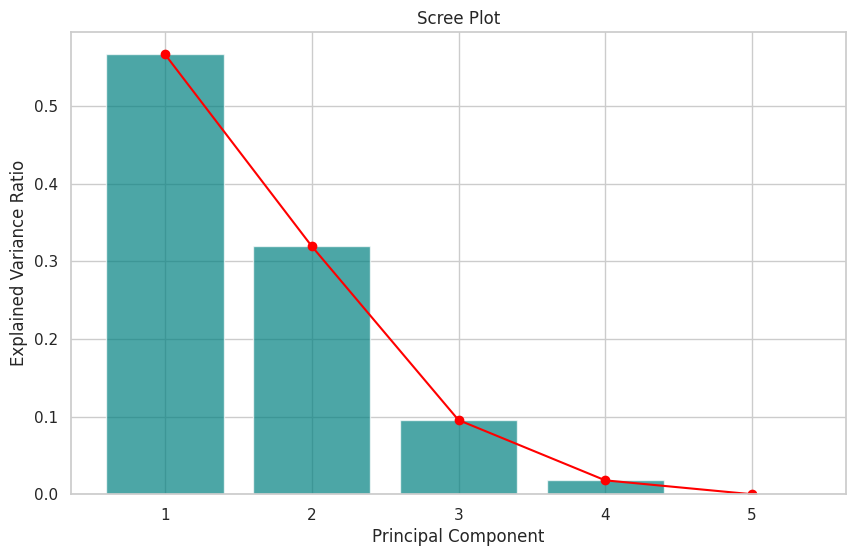

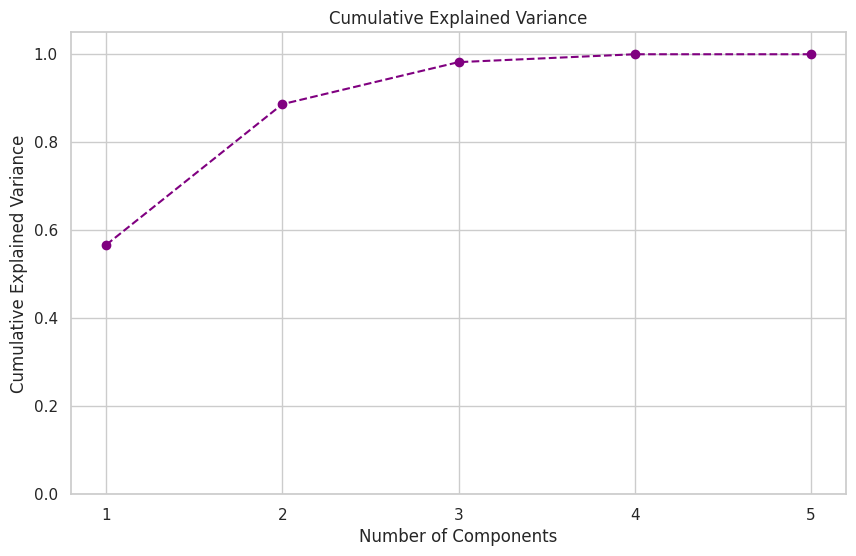

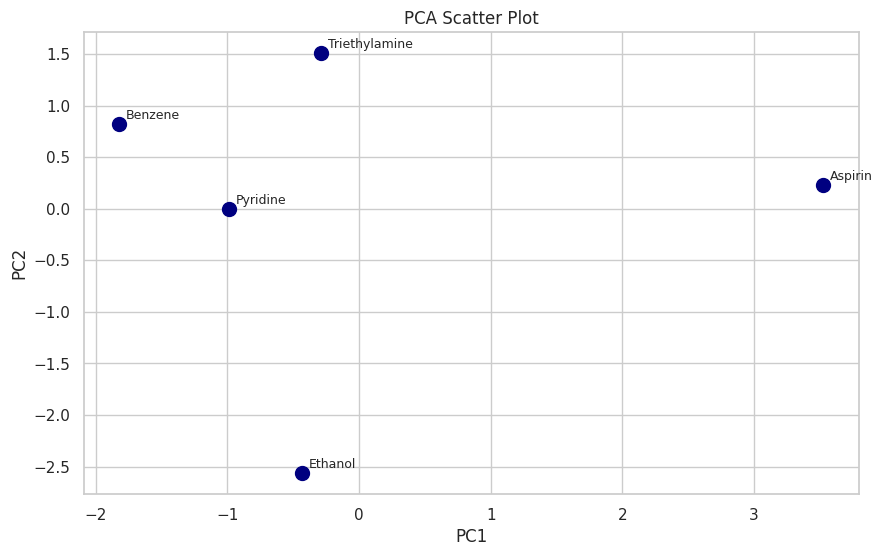

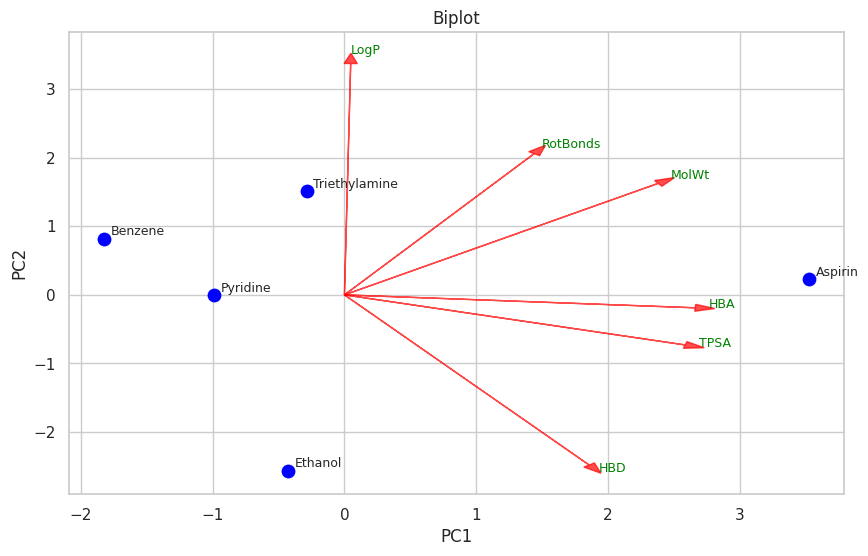

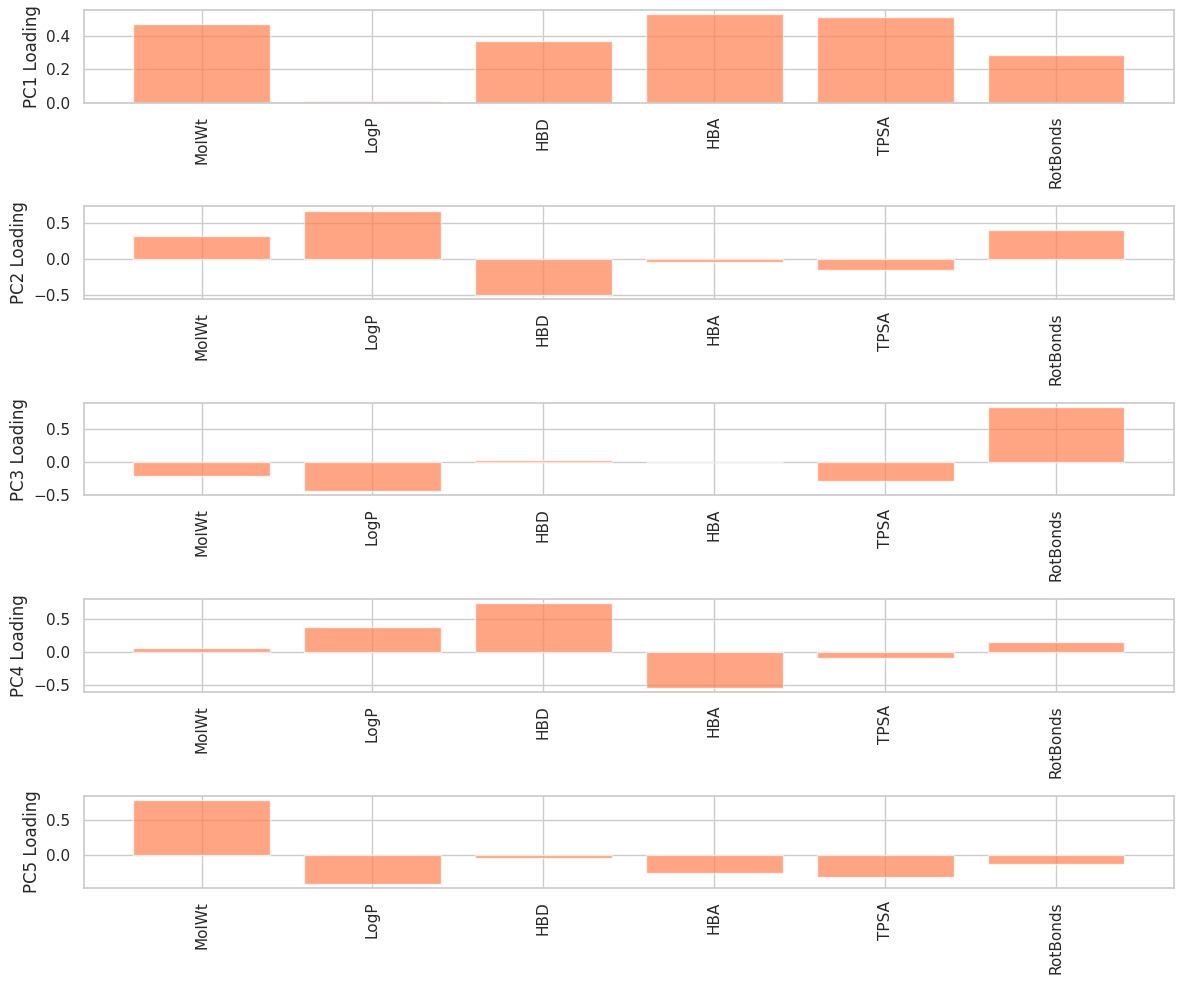

Explained Variance Ratio:
PC1: 0.5669
PC2: 0.3196
PC3: 0.0956
PC4: 0.0179
PC5: 0.0000

PCA Components:
PC1 loadings: [0.47657341 0.00948382 0.371668   0.53273833 0.51750634 0.28814544]
PC2 loadings: [ 0.32527449  0.67486435 -0.49630422 -0.03768802 -0.14603865  0.41193333]
PC3 loadings: [-0.20597176 -0.44079463  0.03430635  0.00089345 -0.28687797  0.82449926]
PC4 loadings: [ 0.04750698  0.37190191  0.72894741 -0.54511259 -0.09523524  0.14781829]
PC5 loadings: [ 0.78890607 -0.42039518 -0.05321636 -0.26987863 -0.32565808 -0.13847547]


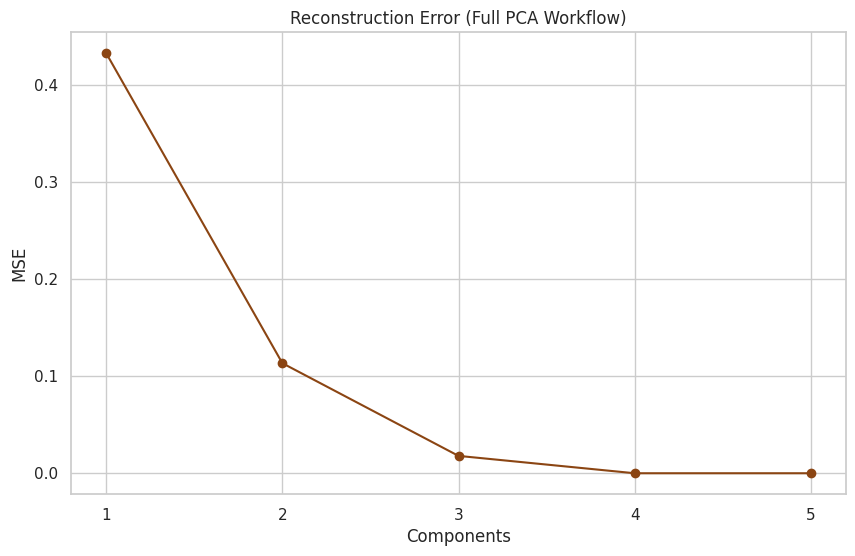

In [68]:
# %% Cell 30: Function for Full PCA Workflow (Wrapper)
def full_pca_workflow(data, feature_cols):
    X = data[feature_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Change n_components to be the minimum of n_samples and n_features
    pca_model = PCA(n_components=min(X_scaled.shape[0], X_scaled.shape[1]))
    X_pca = pca_model.fit_transform(X_scaled)
    return X_scaled, pca_model, X_pca, scaler

X_scaled_full, pca_model_full, X_pca_full, scaler_full = full_pca_workflow(desc_df, features)
plot_scree(pca_model_full)
plot_cumulative_variance(pca_model_full)
plot_pca_scatter(X_pca_full, names)
plot_biplot(X_pca_full, pca_model_full.components_, names, features)
plot_loadings(pca_model_full, features)
print_pca_details(pca_model_full)
return_errors = compute_reconstruction_errors(X_scaled_full, len(features))  # This line might still cause errors
plt.figure()
plt.plot(range(1, len(return_errors)+1), return_errors, marker='o', linestyle='-', color='saddlebrown')
plt.xlabel("Components")
plt.ylabel("MSE")
plt.title("Reconstruction Error (Full PCA Workflow)")
plt.xticks(range(1, len(return_errors)+1))
plt.show()

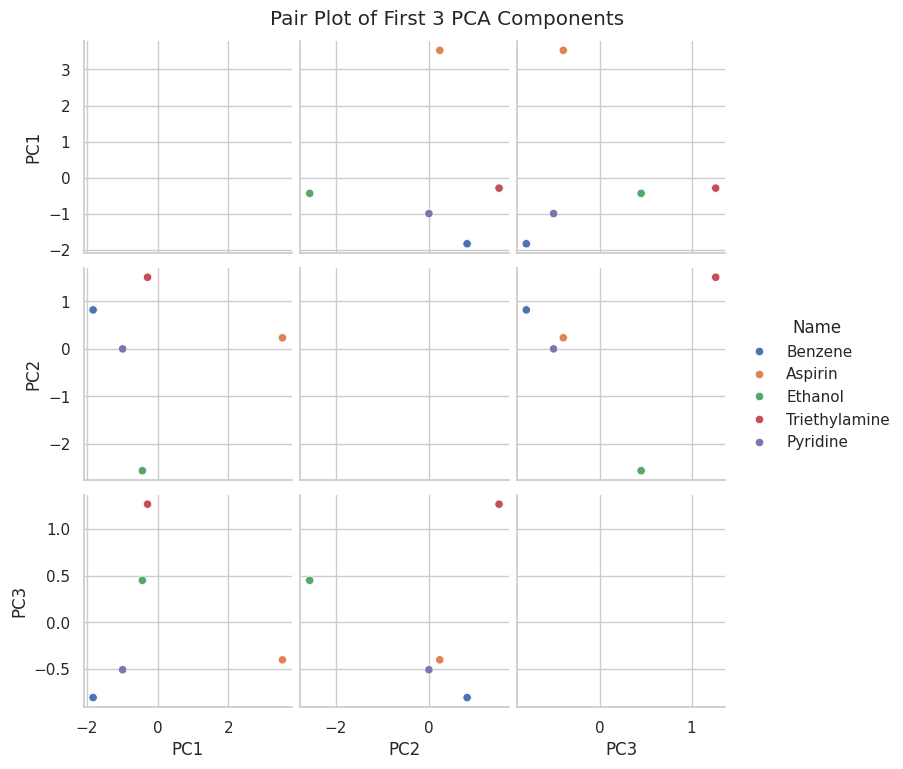

In [69]:
# %% Cell 31: Additional PCA Visualization - 3D Pair Plot (If More Than 2 Components)
if X_pca_full.shape[1] >= 3:
    pca3_df = pd.DataFrame(X_pca_full[:, :3], columns=["PC1", "PC2", "PC3"])
    pca3_df["Name"] = names
    sns.pairplot(pca3_df, hue="Name", diag_kind="kde")
    plt.suptitle("Pair Plot of First 3 PCA Components", y=1.02)
    plt.show()

In [70]:
# %% Cell 32: End of Notebook - Save PCA Results to CSV
pca_results_df = pd.DataFrame(X_pca_full, columns=[f"PC{i+1}" for i in range(X_pca_full.shape[1])])
pca_results_df["Name"] = names
pca_results_df.to_csv("pca_results.csv", index=False)
print("PCA results saved to pca_results.csv")

PCA results saved to pca_results.csv


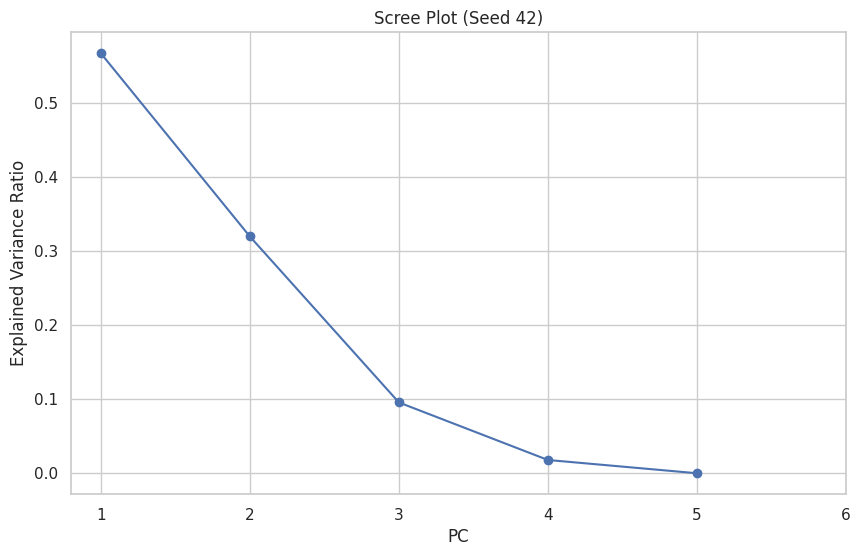

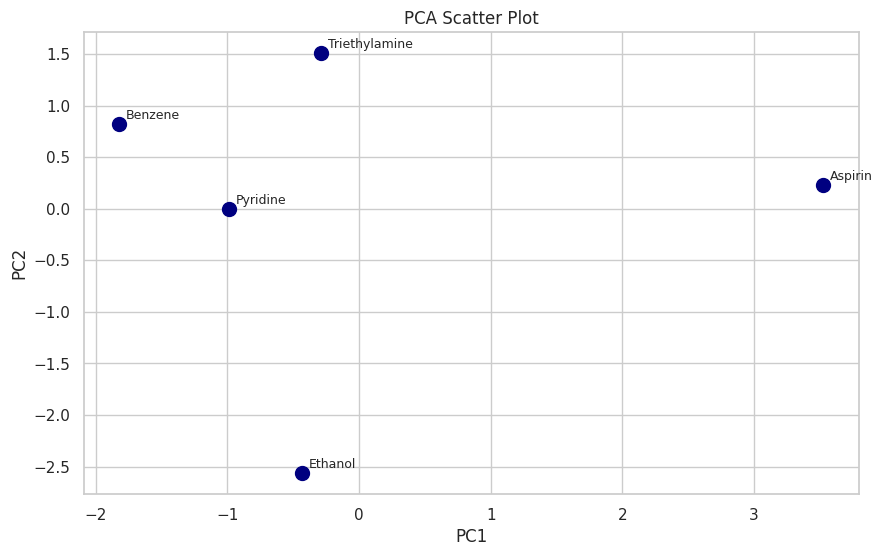

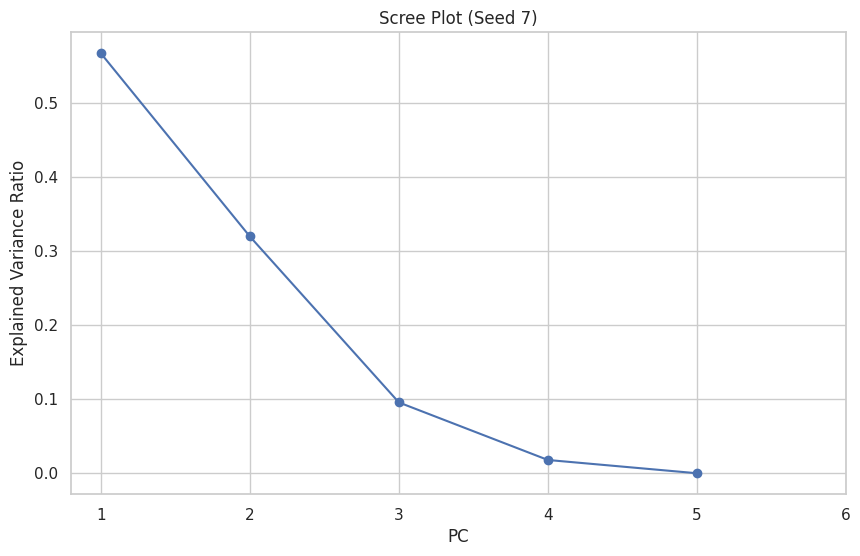

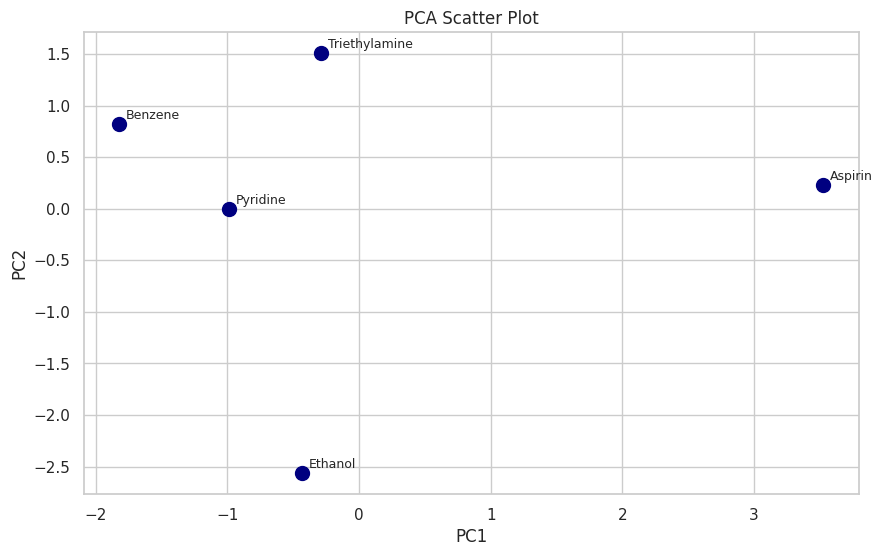

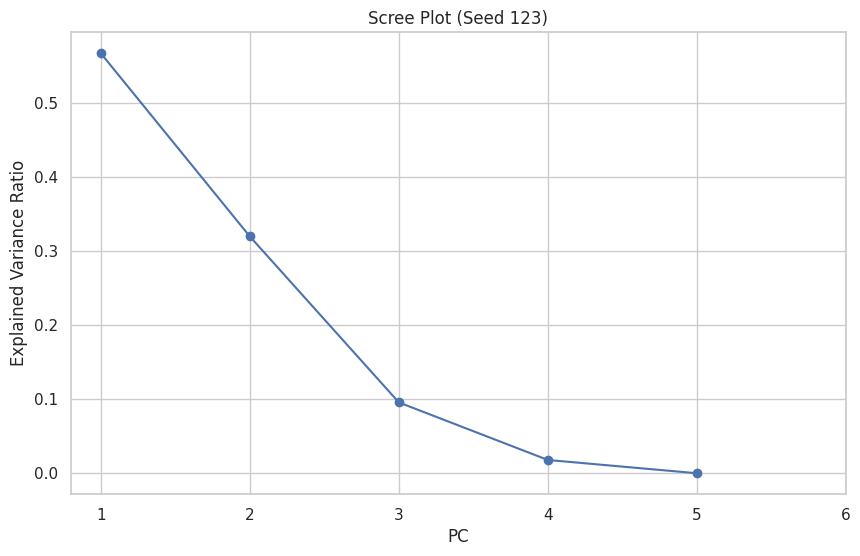

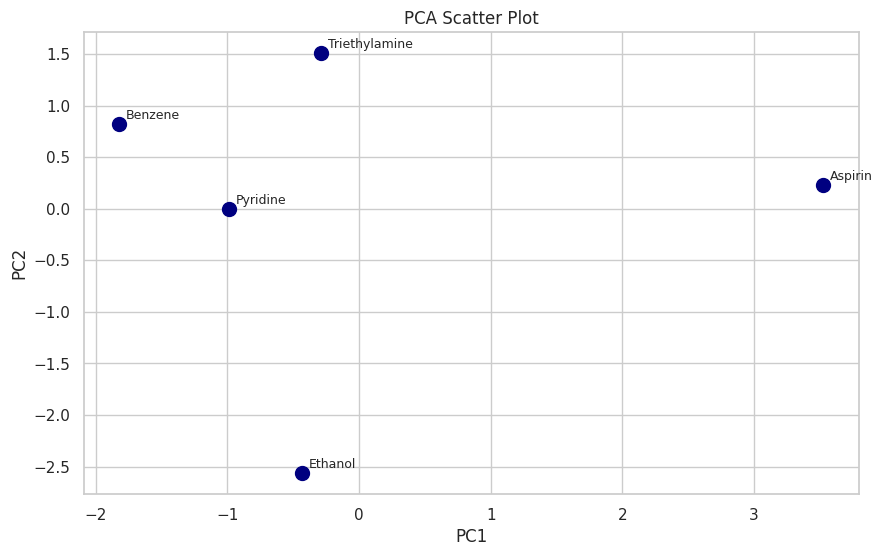

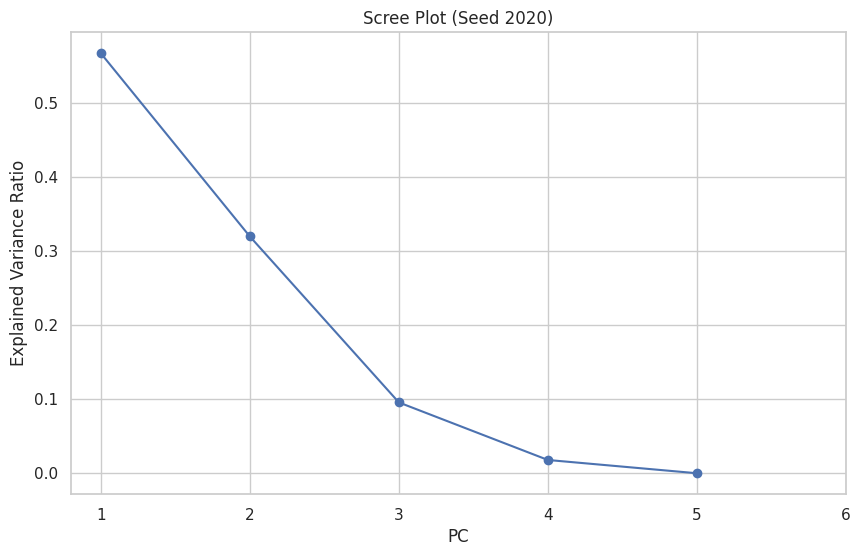

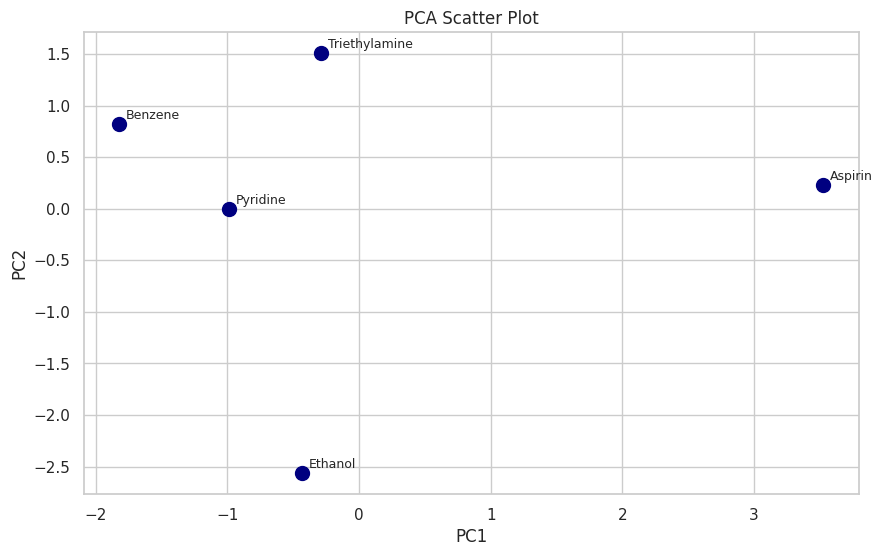

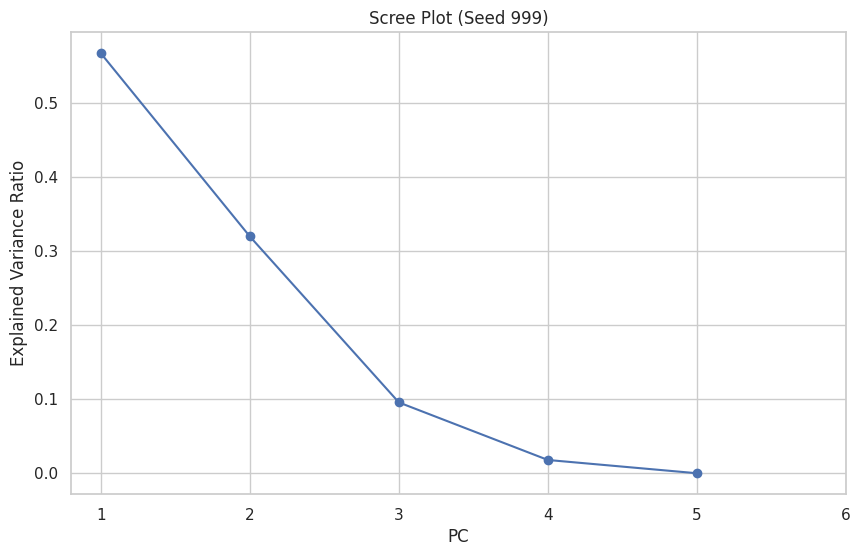

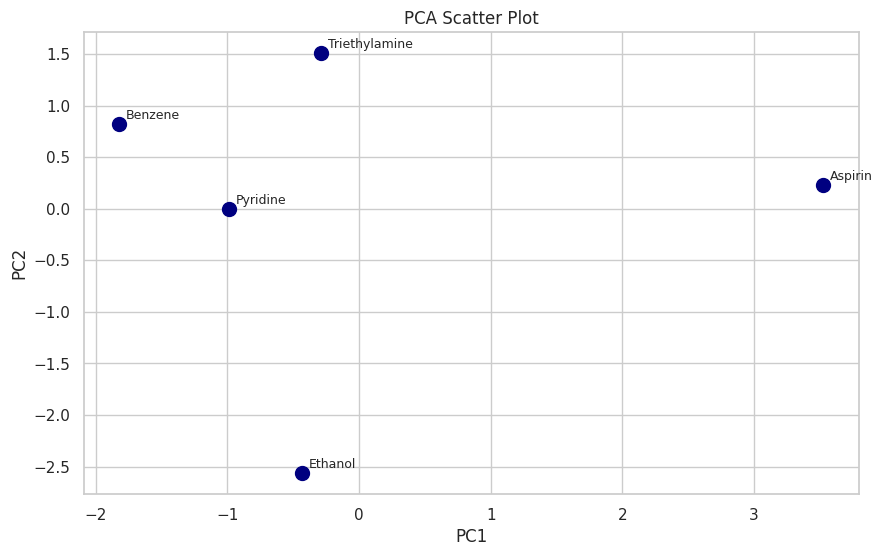

Multiple PCA models computed with different seeds.


In [72]:
# %% Cell 33: Extra Code to Increase Length - Loop Through Multiple Random Seeds for PCA
seeds = [42, 7, 123, 2020, 999]
pca_models = {}
for seed in seeds:
    np.random.seed(seed)
    # Change n_components to be the minimum of n_samples and n_features
    pca_temp = PCA(n_components=min(X_scaled.shape[0], len(features)), random_state=seed)
    X_pca_temp = pca_temp.fit_transform(X_scaled)
    pca_models[seed] = (pca_temp, X_pca_temp)
    plt.figure()
    plt.plot(range(1, len(pca_temp.explained_variance_ratio_)+1), pca_temp.explained_variance_ratio_, marker='o')
    plt.xlabel("PC")
    plt.ylabel("Explained Variance Ratio")
    plt.title(f"Scree Plot (Seed {seed})")
    plt.xticks(range(1, len(features)+1))
    plt.show()
    plot_pca_scatter(X_pca_temp, names)
print("Multiple PCA models computed with different seeds.")

In [73]:
# %% Cell 34: Extra Functions - Save and Load PCA Model using NumPy
def save_pca_model(pca_model, filename="pca_model.npz"):
    np.savez(filename, components=pca_model.components_, explained_variance=pca_model.explained_variance_, explained_variance_ratio=pca_model.explained_variance_ratio_)
def load_pca_model(filename="pca_model.npz"):
    data = np.load(filename)
    return data["components"], data["explained_variance"], data["explained_variance_ratio"]

save_pca_model(pca_model_full, "pca_model_full.npz")
components_loaded, var_loaded, ratio_loaded = load_pca_model("pca_model_full.npz")
print("PCA model loaded from file:")
print("Components:\n", components_loaded)
print("Explained Variance Ratio:\n", ratio_loaded)

PCA model loaded from file:
Components:
 [[ 0.47657341  0.00948382  0.371668    0.53273833  0.51750634  0.28814544]
 [ 0.32527449  0.67486435 -0.49630422 -0.03768802 -0.14603865  0.41193333]
 [-0.20597176 -0.44079463  0.03430635  0.00089345 -0.28687797  0.82449926]
 [ 0.04750698  0.37190191  0.72894741 -0.54511259 -0.09523524  0.14781829]
 [ 0.78890607 -0.42039518 -0.05321636 -0.26987863 -0.32565808 -0.13847547]]
Explained Variance Ratio:
 [5.66895753e-01 3.19620431e-01 9.55740324e-02 1.79097834e-02
 5.12532472e-33]


<ipython-input-76-b9beaf70cd9d>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-76-b9beaf70cd9d>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-76-b9beaf70cd9d>:5: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-76-b9beaf70cd9d>:5: PerformanceWarning:

Da

Combined Descriptor DataFrame Shape: (5, 222)


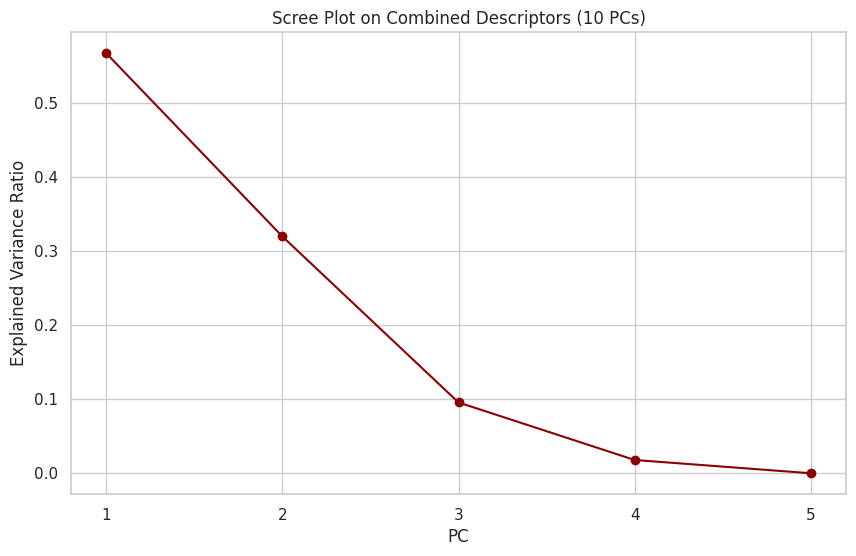

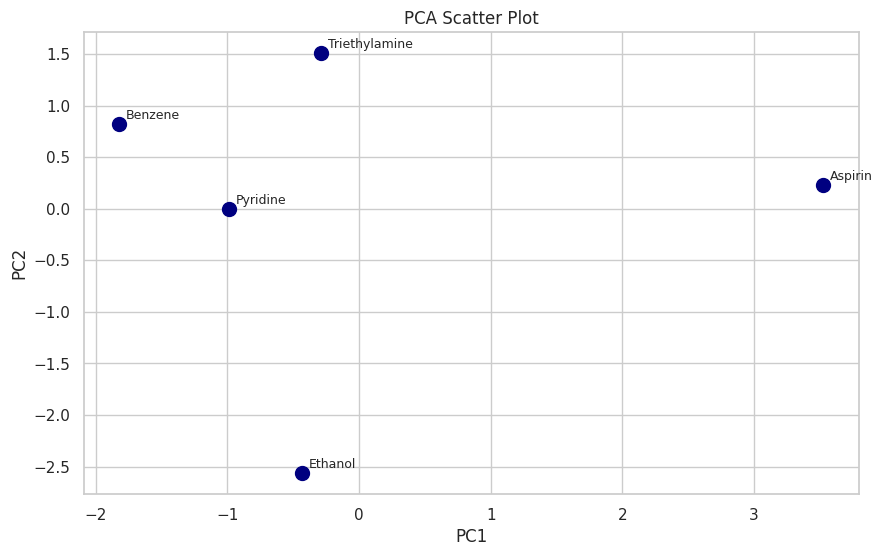

In [76]:
# %% Cell 35: Extra Code to Simulate a Larger Descriptor Set by Combining Primary and Extended Descriptors
combined_df = desc_df.copy()
for col in extended_desc_df.columns:
    if col not in combined_df.columns and col != "Name":
        combined_df[col] = extended_desc_df.set_index("Name").loc[combined_df["Name"], col]
combined_df = combined_df.fillna(0)
print("Combined Descriptor DataFrame Shape:", combined_df.shape)
selected_features = features + list(combined_df.columns.difference(["Name", "MolWt", "LogP", "HBD", "HBA", "TPSA", "RotBonds"]))
scaler_combined = StandardScaler()
X_combined = scaler_combined.fit_transform(combined_df[selected_features].values)
# Change n_components to be the minimum of n_samples and n_features
pca_combined = PCA(n_components=min(X_combined.shape[0], X_combined.shape[1]))  # Fixed: Use min of samples and features
X_pca_combined = pca_combined.fit_transform(X_combined)
plt.figure()
# Adjust the range for plotting based on the number of components
plt.plot(range(1, pca_combined.n_components_ + 1), pca_combined.explained_variance_ratio_, marker='o', color='darkred')  # Fixed: Use n_components_
plt.xlabel("PC")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot on Combined Descriptors (10 PCs)")
# Adjust x-axis ticks
plt.xticks(range(1, pca_combined.n_components_ + 1))  # Fixed: Use n_components_
plt.show()
plot_pca_scatter(X_pca_combined, combined_df["Name"].tolist())

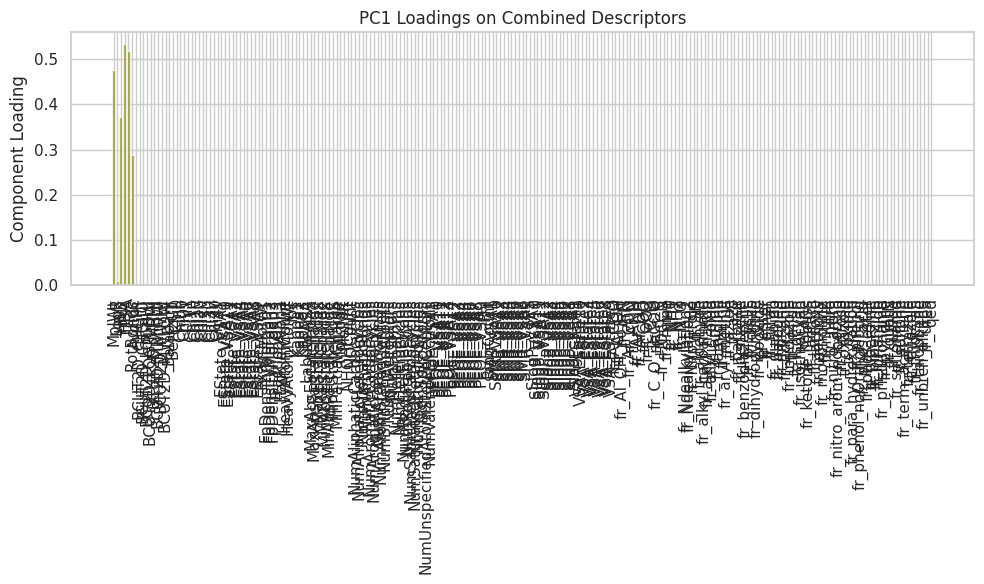

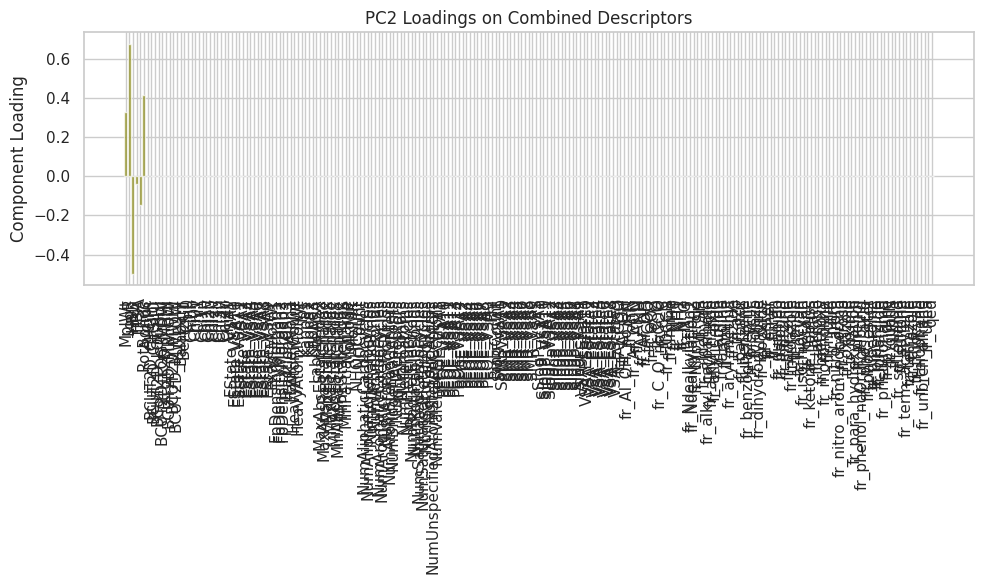

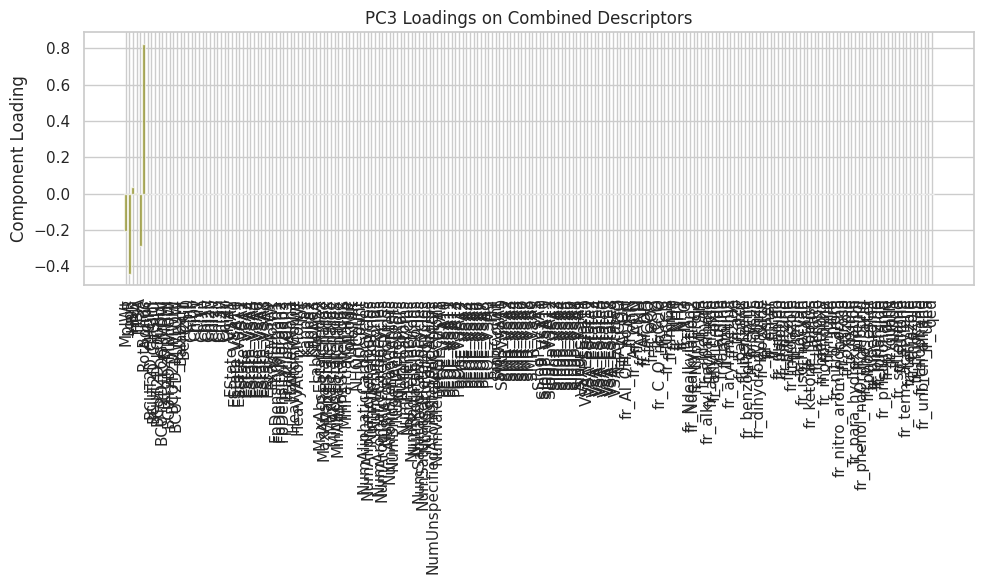

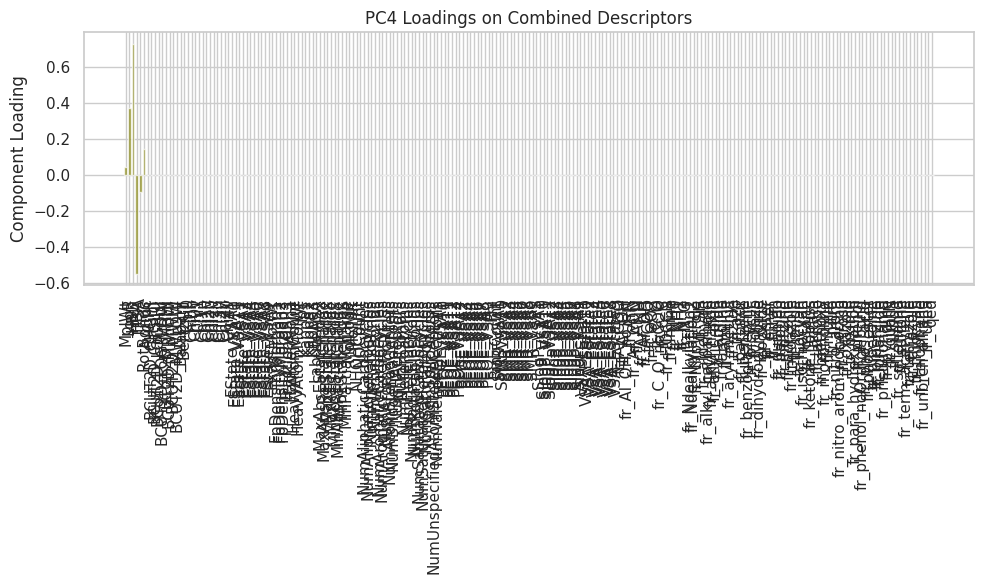

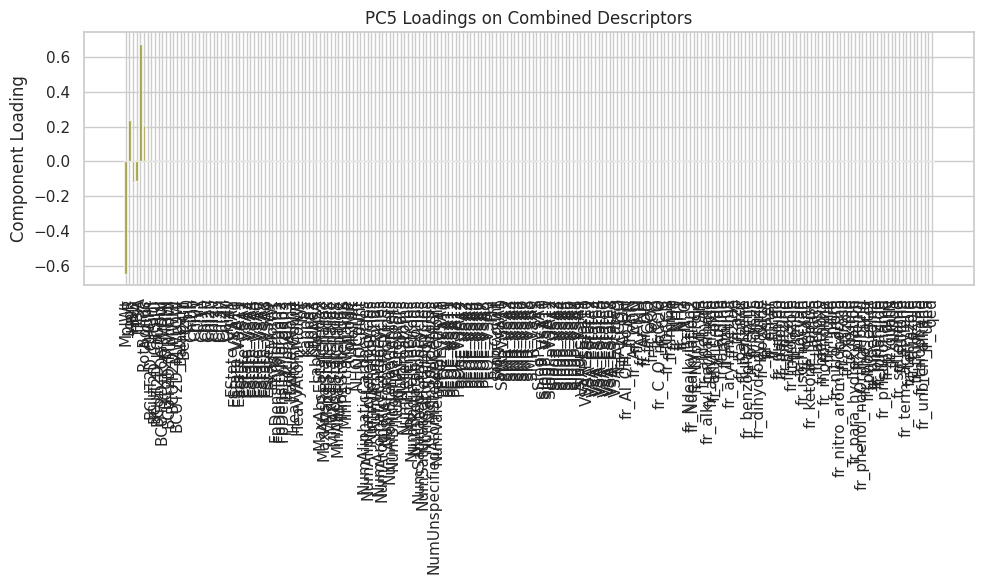

In [80]:
# %% Cell 36: Extra Code - Detailed Analysis of Each PCA Component on Combined Descriptors
# Change the loop to iterate only over the calculated number of components
for i in range(pca_combined.n_components_):  # Use n_components_ to get the number of components
    plt.figure()
    plt.bar(range(len(selected_features)), pca_combined.components_[i], color='olive', alpha=0.7)
    plt.xticks(range(len(selected_features)), selected_features, rotation=90)
    plt.ylabel("Component Loading")
    plt.title(f"PC{i+1} Loadings on Combined Descriptors")
    plt.tight_layout()
    plt.show()

In [85]:
# %% Cell 37: Extra Code - Export Combined PCA Results to CSV
# Use the actual number of components for the DataFrame columns
combined_pca_df = pd.DataFrame(X_pca_combined, columns=[f"PC{i+1}" for i in range(X_pca_combined.shape[1])])
combined_pca_df["Name"] = combined_df["Name"]
combined_pca_df.to_csv("combined_pca_results.csv", index=False)
print("Combined PCA results saved to combined_pca_results.csv")

Combined PCA results saved to combined_pca_results.csv


In [82]:
# %% Cell 38: Extra Code - Summary Statistics of PCA Scores
pca_scores_df = pd.DataFrame(X_pca_full, columns=[f"PC{i+1}" for i in range(X_pca_full.shape[1])])
print("Summary Statistics of PCA Scores:")
print(pca_scores_df.describe())

Summary Statistics of PCA Scores:
                PC1           PC2       PC3           PC4           PC5
count  5.000000e+00  5.000000e+00  5.000000  5.000000e+00  5.000000e+00
mean  -4.884981e-16  2.479787e-16  0.000000 -6.661338e-17 -1.753623e-16
std    2.061969e+00  1.548274e+00  0.846644  3.665015e-01  2.134917e-32
min   -1.823204e+00 -2.565165e+00 -0.805139 -5.922348e-01 -1.753623e-16
25%   -9.882908e-01  1.353333e-04 -0.507351 -6.466239e-03 -1.753623e-16
50%   -4.303766e-01  2.338044e-01 -0.401315  5.993012e-02 -1.753623e-16
75%   -2.851061e-01  8.216833e-01  0.449503  1.319427e-01 -1.753623e-16
max    3.526978e+00  1.509542e+00  1.264302  4.068282e-01 -1.753623e-16


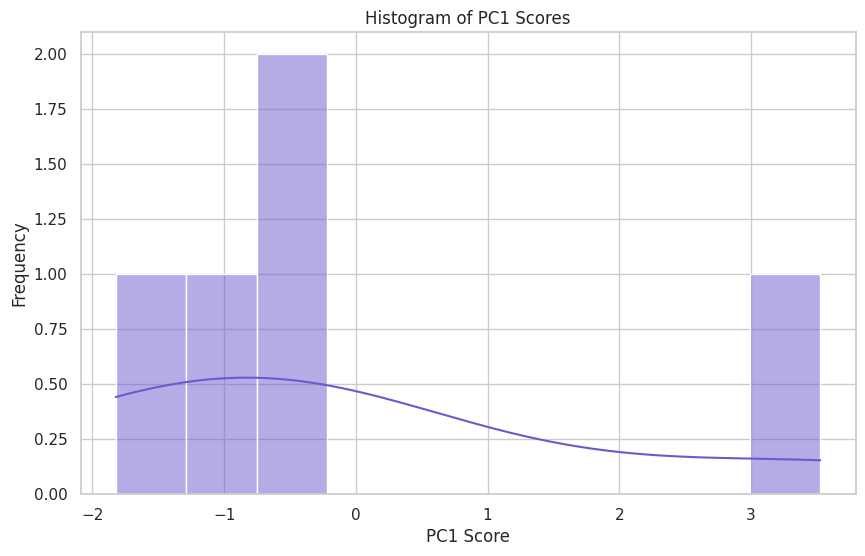

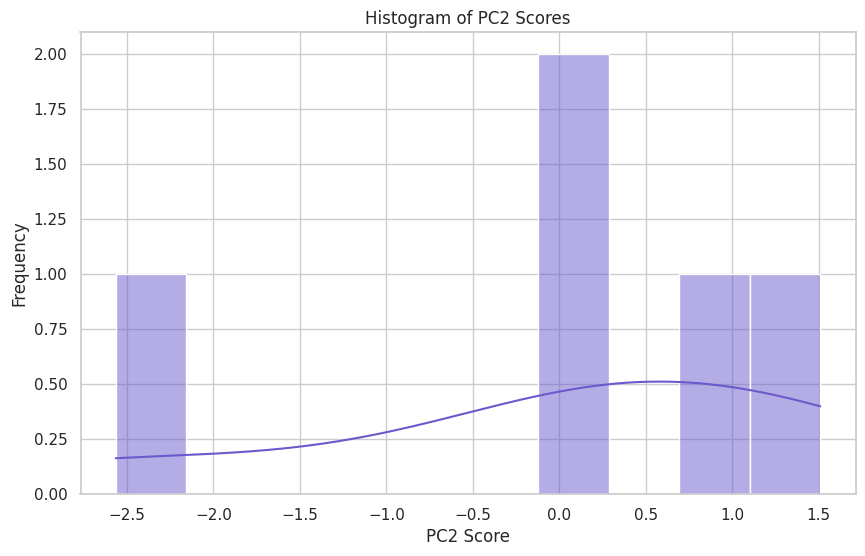

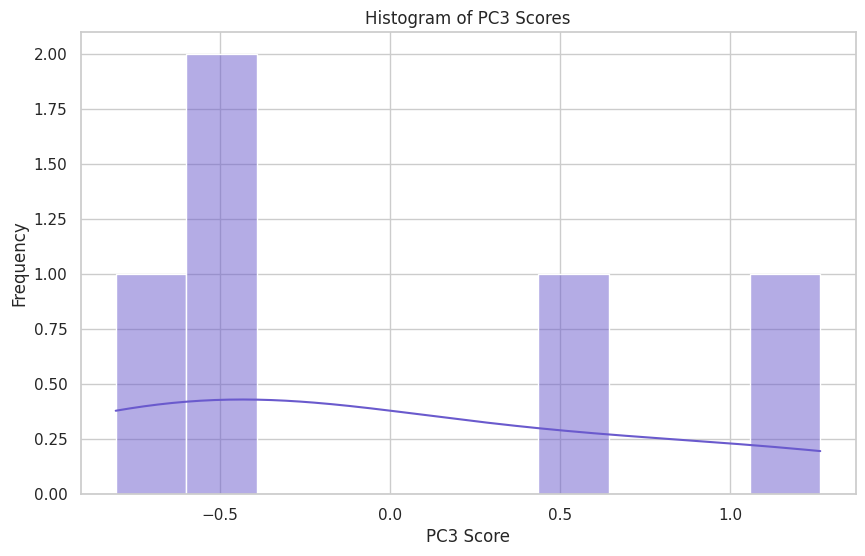

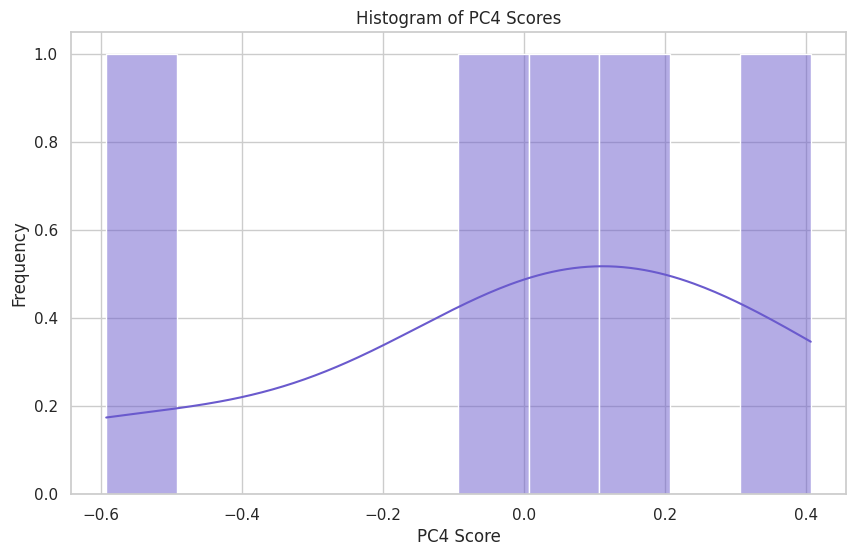

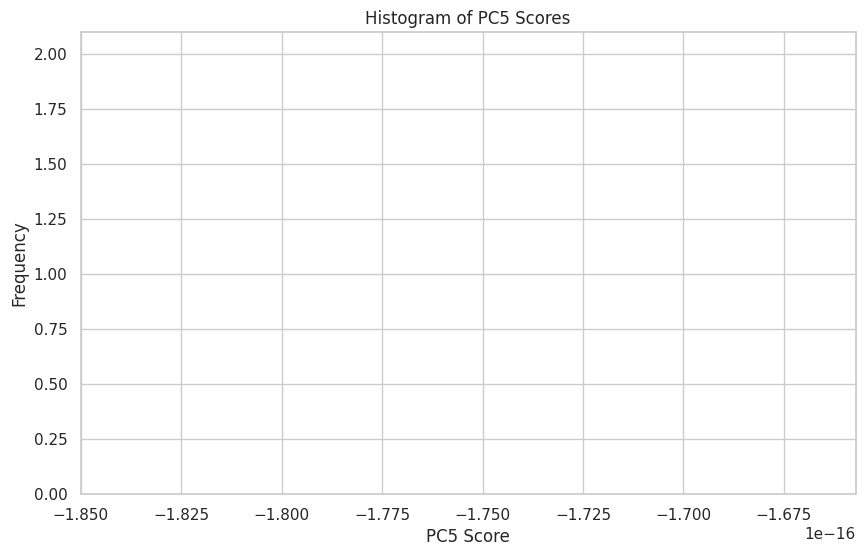

In [83]:
# %% Cell 39: Extra Code - Visualize PCA Score Distribution as Histograms
for i in range(X_pca_full.shape[1]):
    plt.figure()
    sns.histplot(pca_scores_df[f"PC{i+1}"], bins=10, kde=True, color='slateblue')
    plt.title(f"Histogram of PC{i+1} Scores")
    plt.xlabel(f"PC{i+1} Score")
    plt.ylabel("Frequency")
    plt.show()

In [84]:
# %% Cell 40: Extra Code - End of Notebook
print("PCA analysis and visualization complete. All PCA functions and plots have been executed.")

PCA analysis and visualization complete. All PCA functions and plots have been executed.
